In [1]:
import ast
from collections import Counter
from gensim import utils, matutils 
from gensim.corpora.dictionary import Dictionary
from gensim.utils import deprecated
import itertools
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as LA
from numpy.random import binomial
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from numpy.linalg import norm
import math, copy, time
import warnings 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import load_model

import os, sys, re, io, nltk, torch
import pandas as pd

from scipy import stats
from scipy.stats import bernoulli
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
from scipy.spatial import distance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score, precision_score

from six import string_types, integer_types
from six.moves import zip, range
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm, trange
import time
import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()


'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #print ("mask para attn...", mask)
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=50):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_text=x.data[:,0][:,None,:]
        x_machines=x.data[:,1:]
        
        x_return = x_machines* x_text
        return self.dropout(x_return)
    
class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=50):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)   

    
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #print ("Rate de Noam_opt", self._rate, self._step)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        #print ("nuevo Y en simplelosscompute", y_new, "antes era", y)
        # ahora
        #y_new=(y.float()).int()
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])

def data_gen(batch_size,mode,n_machines,new_matrix):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]   
        np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['tweet_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=test['tweet_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    #print ("los indices de train k voy a acceder random son", x_data[0])
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        #print ("transformando batch", batch)
        temp=[]
        for pos in batch:
            #print("en especifico el numerito", pos)
            temp2=[index_embeddings[pos+5]]#fromId2num[objs[exam]]] ### obj evaluado en maquinas  
            #print ("me dice que es el embed en index", temp2)
            for m in range(n_machines): 
                #print ("machine ",m,"dice:", np.argmax(new_matrix[m][pos])+1)
                temp2= temp2 + [np.argmax(new_matrix[m][pos])+1] 
                #matrix[4][cosa-5])+1)
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " <html> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " <number> ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB
Se encontraron 1193514 terminos con sus vectores de embedding.


In [2]:
train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/train_format.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/val_format.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/test_format.csv")

dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

22107

In [3]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

        
glove_matrix = np.zeros((k, g_dim))

for word, i in Word2Index_valid.items():
    vector = embeddings_index.get(word)    
    glove_matrix[i] = vector
    
glove_matrix.shape

(14642, 200)

In [4]:
print (len(Word2Index_valid.keys()))

14641


In [5]:
len(Word2Index.keys())

22107

In [6]:
#transf = Normalizer().fit(glove_matrix) 
#M_GLOVE_space=transf.transform(glove_matrix)
M_GLOVE_space=glove_matrix

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [7]:
from models import *

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        #print ("aux original", aux)
        #print ("aux restado...",aux-np.ones(aux.shape))
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
MAX_LEN = 33

print ("Conteo por stance val\n", Counter(val['Label']))
print ("Conteo por stance test\n", Counter(test['Label']))


Conteo por stance val
 Counter({'NonH': 1493, 'SexualH': 525, 'IndirectH': 71, 'PhysicalH': 36})
Conteo por stance test
 Counter({'NonH': 1601, 'SexualH': 340, 'IndirectH': 106, 'PhysicalH': 76})


In [8]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]


In [9]:
ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

(2123, 33, 200)

In [10]:
del embeddings_index

In [11]:
from bert_serving.client import BertClient
bc = BertClient()

In [12]:
class_weights

array([1., 1., 1., 1.])

### 0.0 No CW

Entrenando Run # 1





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.4454291044776119 	F-macro_val: 0.20749544685634536
Epoch 10 	acc_val: 0.8908582089552238 	F-macro_val: 0.4462304870402053
Epoch 20 	acc_val: 0.8908582089552238 	F-macro_val: 0.4453044563688648
Epoch 30 	acc_val: 0.8913246268656716 	F-macro_val: 0.4463526384242481
Epoch 40 	acc_val: 0.8917910447761194 	F-macro_val: 0.4437137695551883
Epoch 50 	acc_val: 0.8917910447761194 	F-macro_val: 0.4454603027547583
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


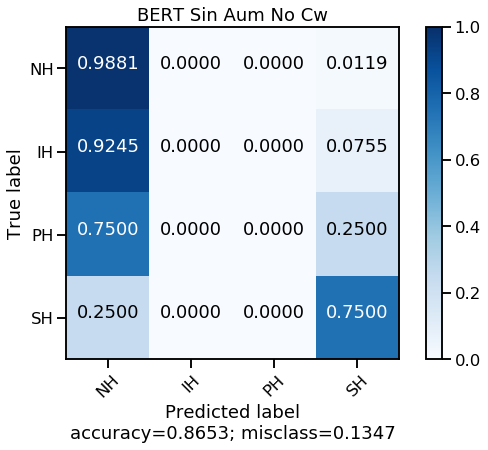

Test_ acc: 0.8652849740932642
Test_ f1 none: [0.92433538 0.         0.         0.79563183]
Test_ f1 macro: 0.4299918008990298


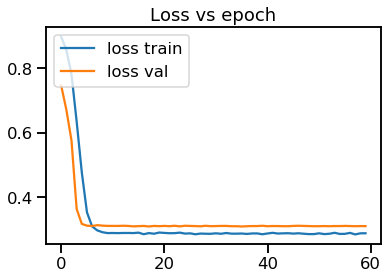

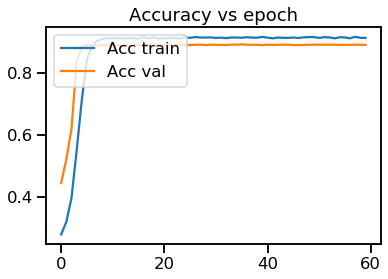

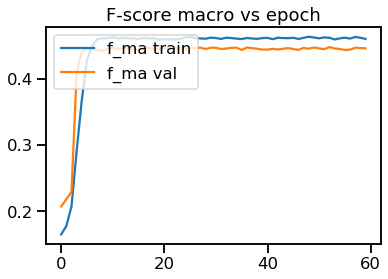

Encoder Layer Attention head 0


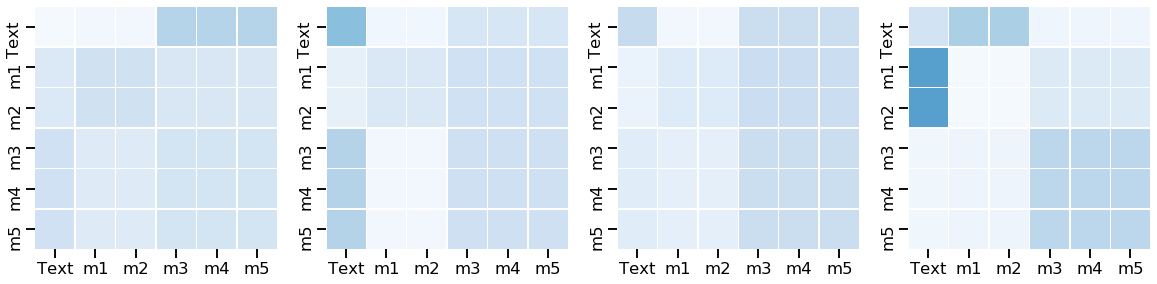

Encoder Layer Attention head 1


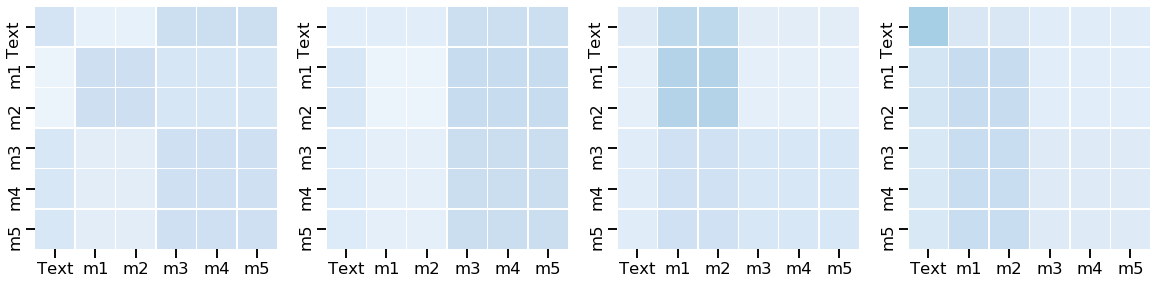

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.22667910447761194 	F-macro_val: 0.1749076493095128
Epoch 10 	acc_val: 0.8899253731343284 	F-macro_val: 0.4397869901564935
Epoch 20 	acc_val: 0.8913246268656716 	F-macro_val: 0.4459028522968272
Epoch 30 	acc_val: 0.8922574626865671 	F-macro_val: 0.4465250870965891
Epoch 40 	acc_val: 0.8941231343283582 	F-macro_val: 0.4468560971314951
Epoch 50 	acc_val: 0.8922574626865671 	F-macro_val: 0.44497016415093293
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


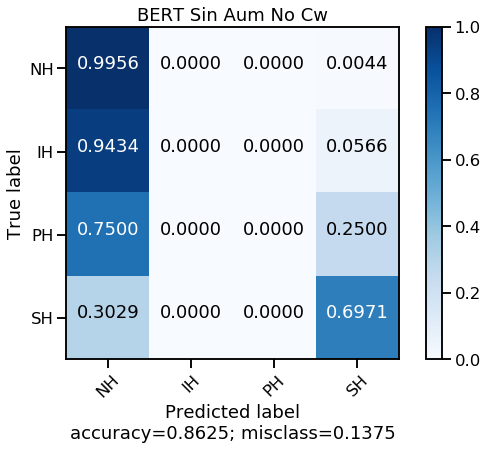

Test_ acc: 0.8624587847385775
Test_ f1 none: [0.92272069 0.         0.         0.77832512]
Test_ f1 macro: 0.42526145444953767


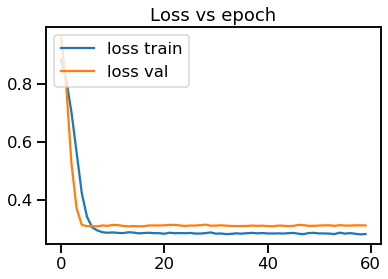

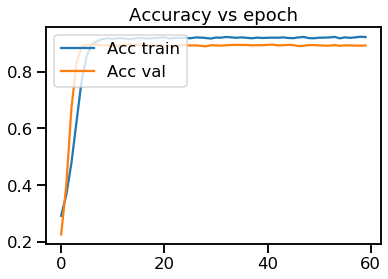

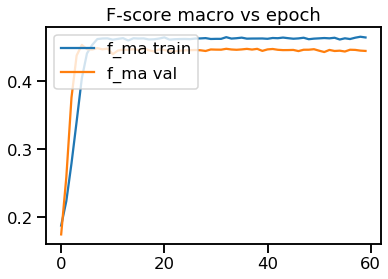

Encoder Layer Attention head 0


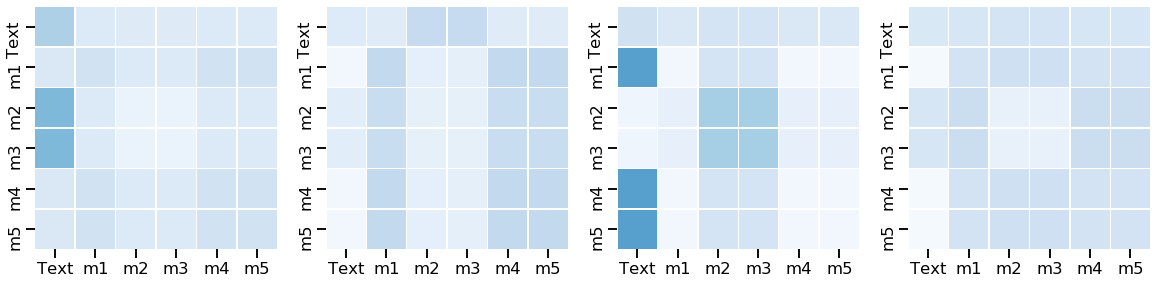

Encoder Layer Attention head 1


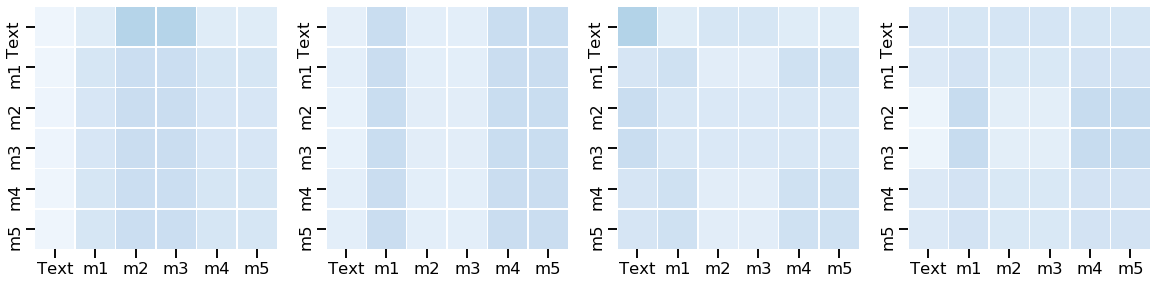

Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.8680037313432836 	F-macro_val: 0.4360821548870382
Epoch 10 	acc_val: 0.8931902985074627 	F-macro_val: 0.4479756632934347
Epoch 20 	acc_val: 0.8941231343283582 	F-macro_val: 0.44476061989682053
Epoch 30 	acc_val: 0.8931902985074627 	F-macro_val: 0.4457566184522308
Epoch 40 	acc_val: 0.8931902985074627 	F-macro_val: 0.44593596727754914
Epoch 50 	acc_val: 0.8931902985074627 	F-macro_val: 0.44768087567834025
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


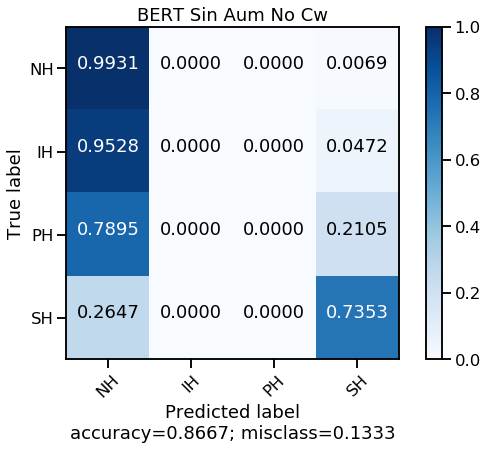

Test_ acc: 0.8666980687706076
Test_ f1 none: [0.92388146 0.         0.         0.80385852]
Test_ f1 macro: 0.4319349962913209


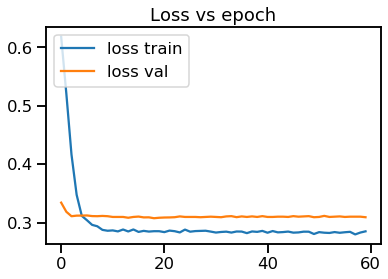

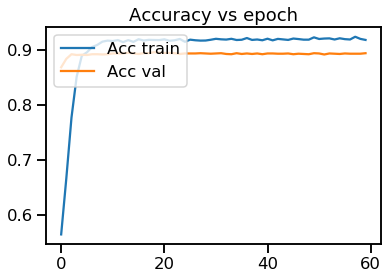

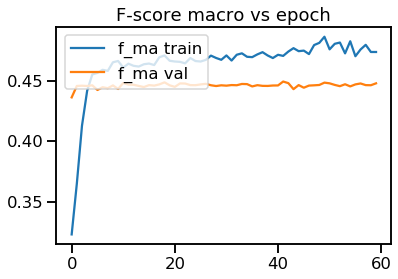

Encoder Layer Attention head 0


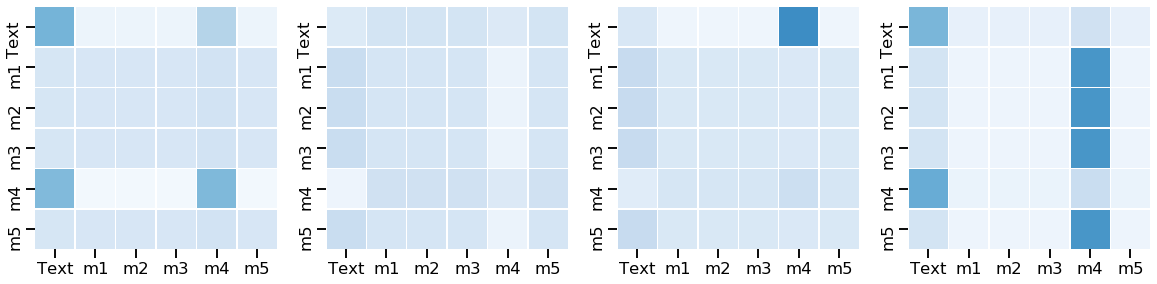

Encoder Layer Attention head 1


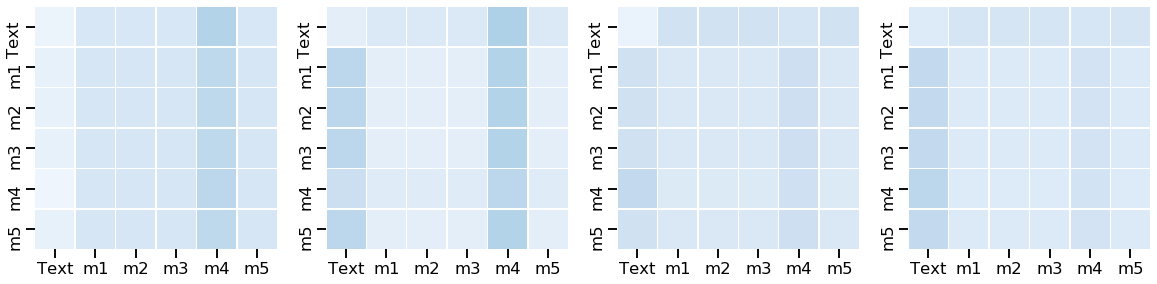

Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.34654850746268656 	F-macro_val: 0.18487788290041574
Epoch 10 	acc_val: 0.8964552238805971 	F-macro_val: 0.44923640947673876
Epoch 20 	acc_val: 0.8964552238805971 	F-macro_val: 0.4483552397789161
Epoch 30 	acc_val: 0.8973880597014925 	F-macro_val: 0.4492181612158896
Epoch 40 	acc_val: 0.8969216417910447 	F-macro_val: 0.447978175167202
Epoch 50 	acc_val: 0.8959888059701493 	F-macro_val: 0.44903133696013636
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


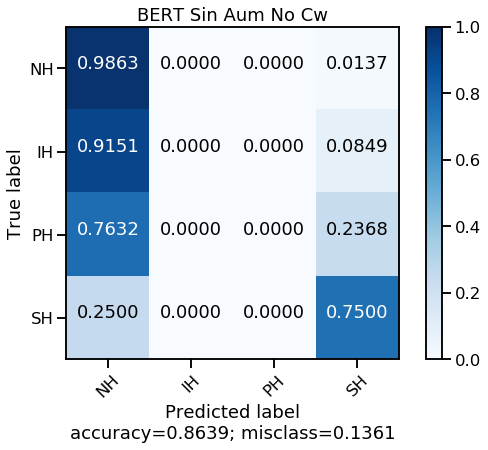

Test_ acc: 0.8638718794159209
Test_ f1 none: [0.92339181 0.         0.         0.79192547]
Test_ f1 macro: 0.42882931967600163


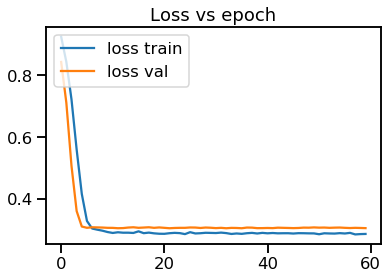

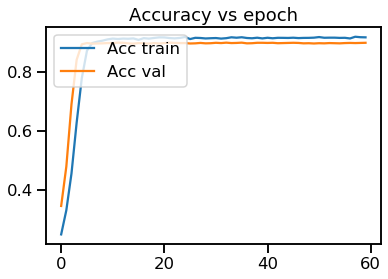

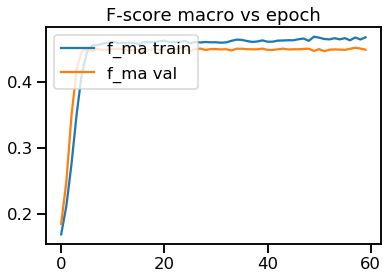

Encoder Layer Attention head 0


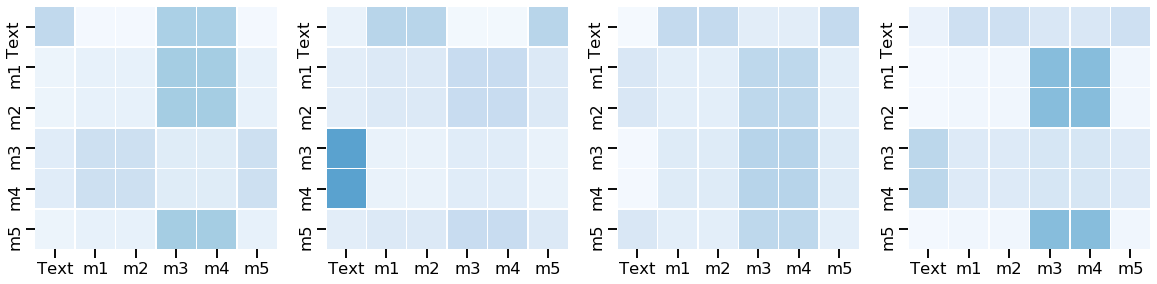

Encoder Layer Attention head 1


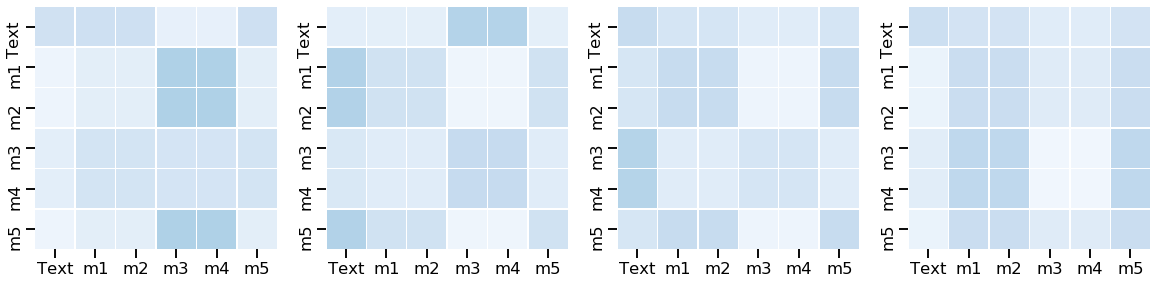

Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.12733208955223882 	F-macro_val: 0.1084320624632337
Epoch 10 	acc_val: 0.8941231343283582 	F-macro_val: 0.44811743021838496
Epoch 20 	acc_val: 0.8941231343283582 	F-macro_val: 0.4470775904912712
Epoch 30 	acc_val: 0.8955223880597015 	F-macro_val: 0.4462476784549386
Epoch 40 	acc_val: 0.8908582089552238 	F-macro_val: 0.44388830543046215
Epoch 50 	acc_val: 0.894589552238806 	F-macro_val: 0.44770657119331125
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


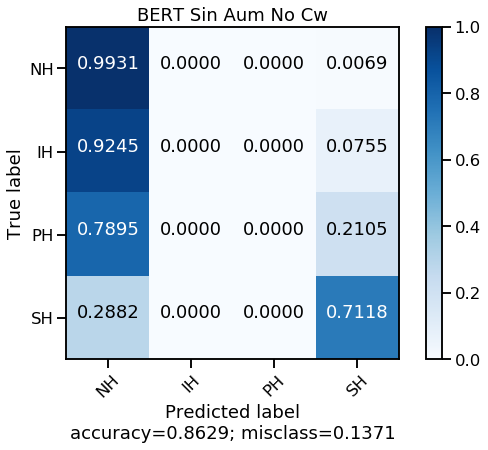

Test_ acc: 0.8629298162976919
Test_ f1 none: [0.92254134 0.         0.         0.78444084]
Test_ f1 macro: 0.42674554577089796


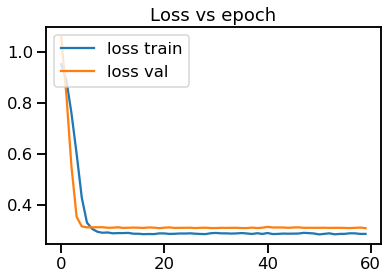

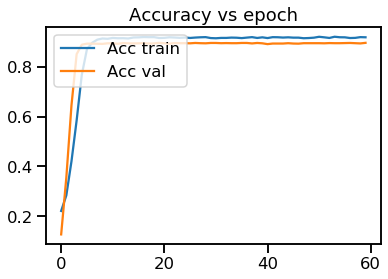

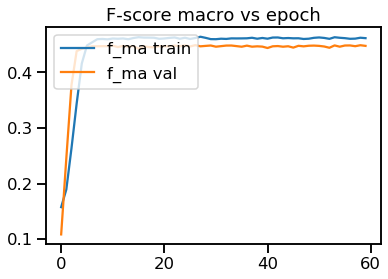

Encoder Layer Attention head 0


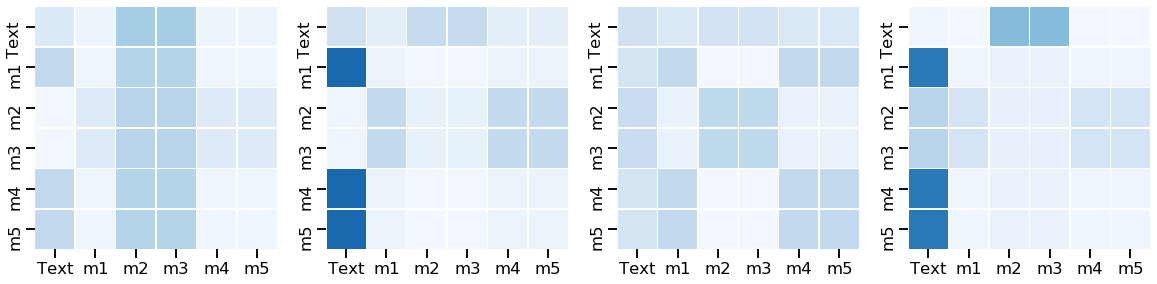

Encoder Layer Attention head 1


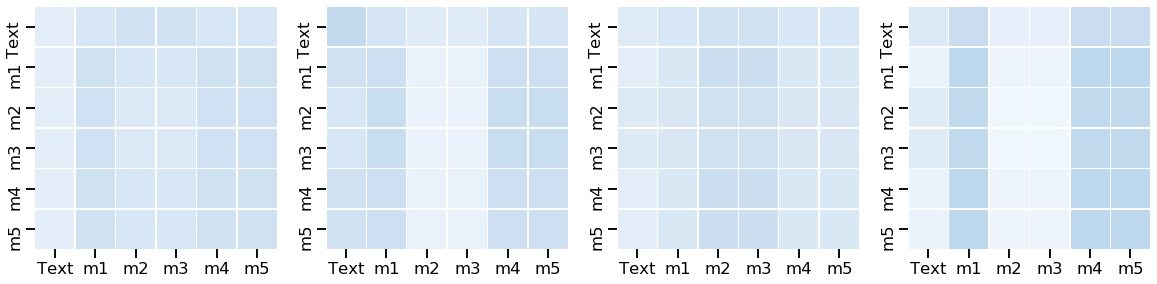

In [13]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    cnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn1_'+str(trans)+'-exec_15.h5')
    cnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn2_'+str(trans)+'-exec_15.h5')
    rnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn1_'+str(trans)+'-exec_8.h5')
    rnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn2_'+str(trans)+'-exec_15.h5')
    rnn3 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn3_'+str(trans)+'-exec_8.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    b_dim=768
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    
    espacio=[np.ones(b_dim)]
    #Ks=np.load("../../BERTransformer/Orthogonals_768.npy")
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok, sentence_valid = my_tokenizer(cleaner(tw_tr)[1])  #cleaner: raw, no cleaner:augmented version
                
        final=' '
        frase=[final.join(sentence_valid)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 2, 4000,torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-3))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        hist_train_loss.append(loss_train)
        hist_train_acc.append(acc_train)
        hist_train_fma.append(fma_train)
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
        hist_val_loss.append(loss_val)
        hist_val_acc.append(acc_val)
        hist_val_fma.append(fma_val)
        
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"BERT Sin Aum No Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    plt.plot(hist_train_loss, label='loss train')
    plt.plot(hist_val_loss,label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch")
    plt.show()

    plt.plot(hist_train_acc, label='Acc train')
    plt.plot(hist_val_acc, label='Acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch")
    plt.show()

    plt.plot(hist_train_fma, label='f_ma train')
    plt.plot(hist_val_fma, label='f_ma val')
    plt.legend(loc='upper left')
    plt.title("F-score macro vs epoch")
    plt.show()
    
    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        plt.show()

Acc: 0.8642487046632125
F-score: 0.42855262341735756
(0.0_No CW) 15-8e NIPS: 0.9233741380789837 0.0 0.0 0.7908363555904467


Confusion counts
[[7935.    0.    0.   70.]
 [ 494.    0.    0.   36.]
 [ 292.    0.    0.   88.]
 [ 461.    0.    0. 1239.]]


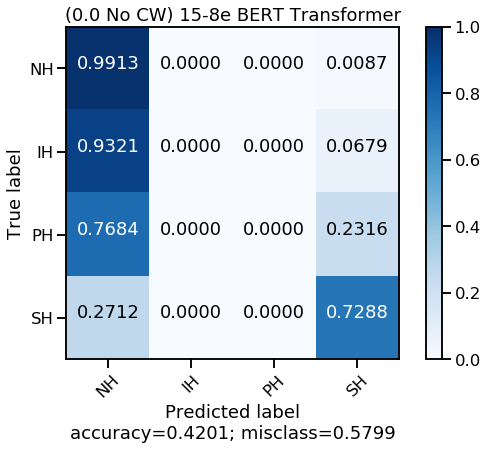

In [14]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_No CW) 15-8e NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.0 No CW) 15-8e BERT Transformer", cmap='Blues')

Encoder Layer Attention head Promedio 0


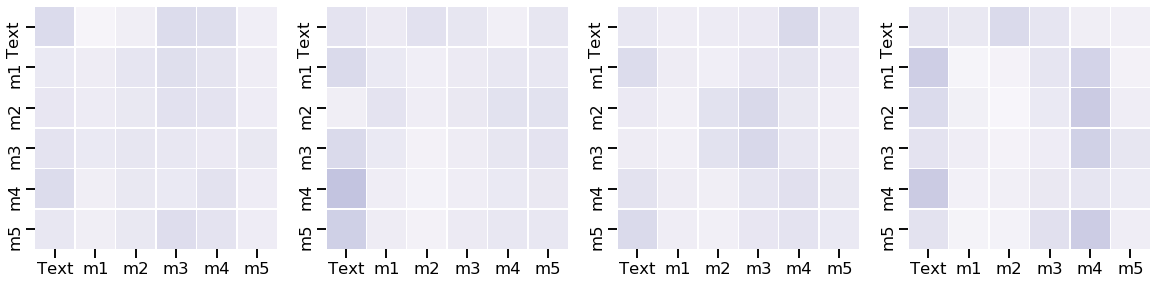

Encoder Layer Attention head Promedio 1


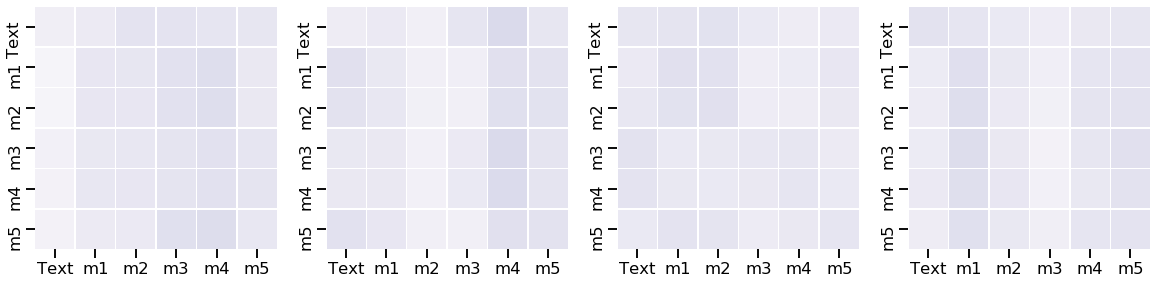

In [15]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Purples", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()
    
for h in range(2):
    for hy in range(4):
        to_mean=dict_attn_enc[str(h)+str(hy)]
        at=np.zeros((6,6))
        for m in to_mean:
            at+=m.numpy() 
        global_attn.append(at/5.)
        
np.save("Attn_SinAum_BERT_NoCW_ECML_60e_24000.npy", global_attn)

### 0.0 Con CW

In [16]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)

print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]


Entrenando Run # 1
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.23180970149253732 	F-macro_val: 0.17010210265361161
Epoch 10 	acc_val: 0.8759328358208955 	F-macro_val: 0.4520015094919845
Epoch 20 	acc_val: 0.8843283582089553 	F-macro_val: 0.4534453217956787
Epoch 30 	acc_val: 0.8861940298507462 	F-macro_val: 0.4582034378783663
Epoch 40 	acc_val: 0.886660447761194 	F-macro_val: 0.46298731731986953
Epoch 50 	acc_val: 0.8875932835820896 	F-macro_val: 0.4571829930770007
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


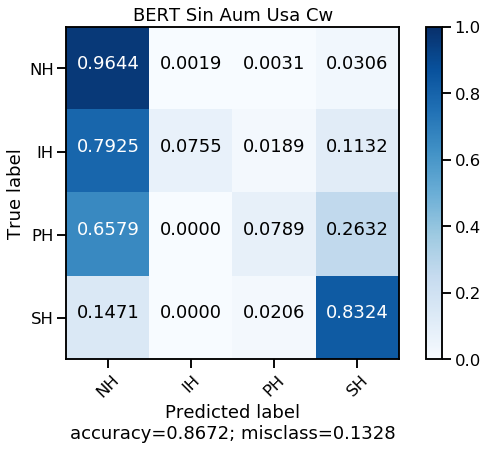

Test_ acc: 0.867169100329722
Test_ f1 none: [0.92760589 0.13675214 0.125      0.80397727]
Test_ f1 macro: 0.4983338242833399


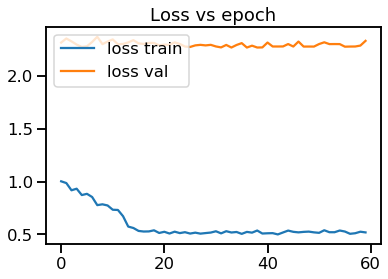

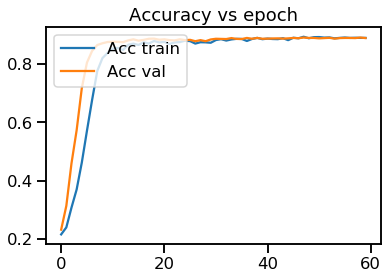

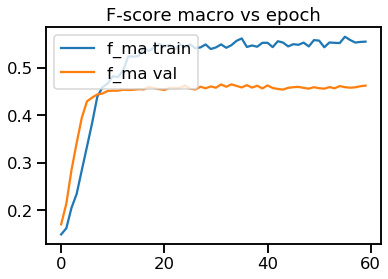

Encoder Layer Attention head 0


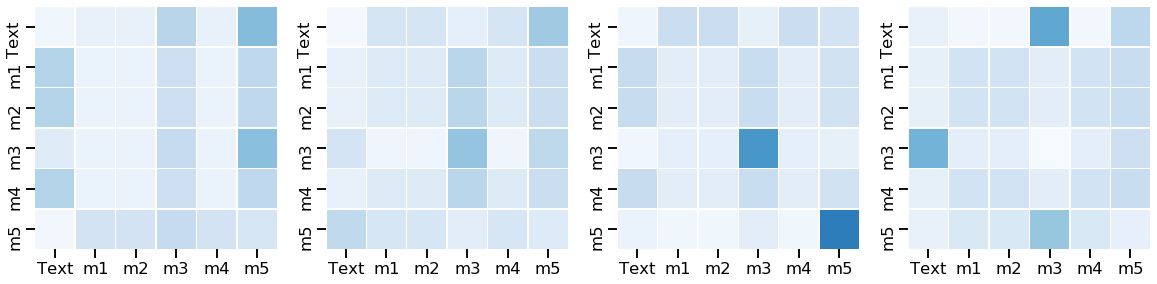

Encoder Layer Attention head 1


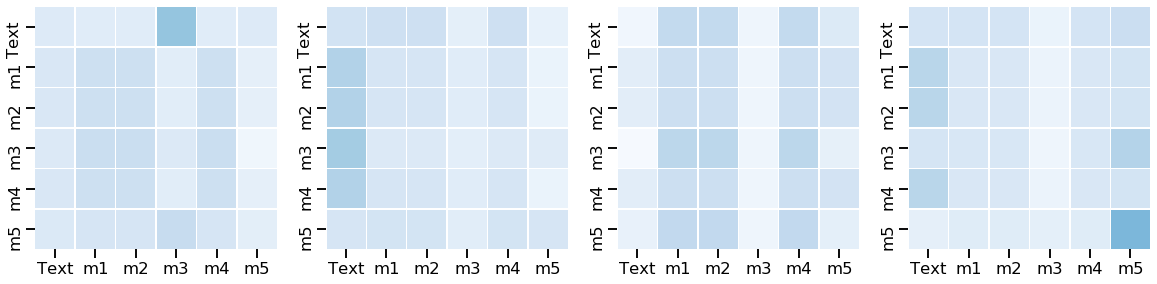

Entrenando Run # 2
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.15345149253731344 	F-macro_val: 0.11836536903970271
Epoch 10 	acc_val: 0.8451492537313433 	F-macro_val: 0.49191581017141467
Epoch 20 	acc_val: 0.8759328358208955 	F-macro_val: 0.4613308889718775
Epoch 30 	acc_val: 0.8684701492537313 	F-macro_val: 0.4853535418111171
Epoch 40 	acc_val: 0.8717350746268657 	F-macro_val: 0.485160649337115
Epoch 50 	acc_val: 0.8759328358208955 	F-macro_val: 0.4844274543090392
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


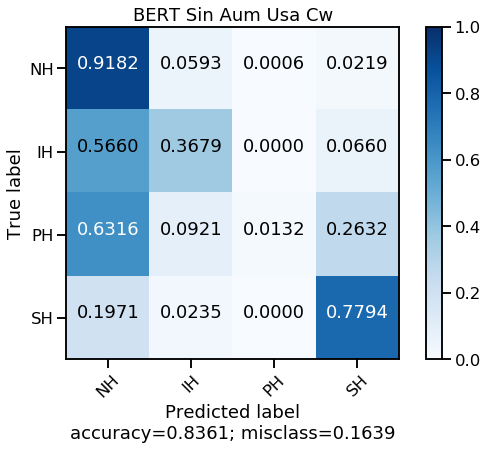

Test_ acc: 0.8360810174281676
Test_ f1 none: [0.90573013 0.30588235 0.02564103 0.7946027 ]
Test_ f1 macro: 0.5079640516557238


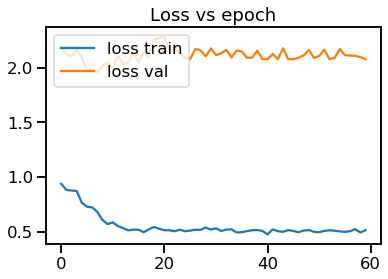

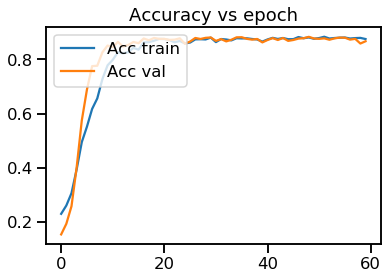

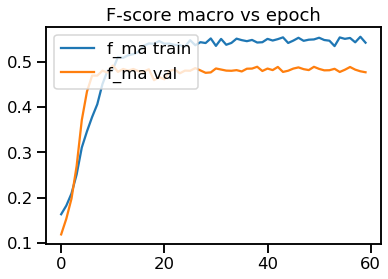

Encoder Layer Attention head 0


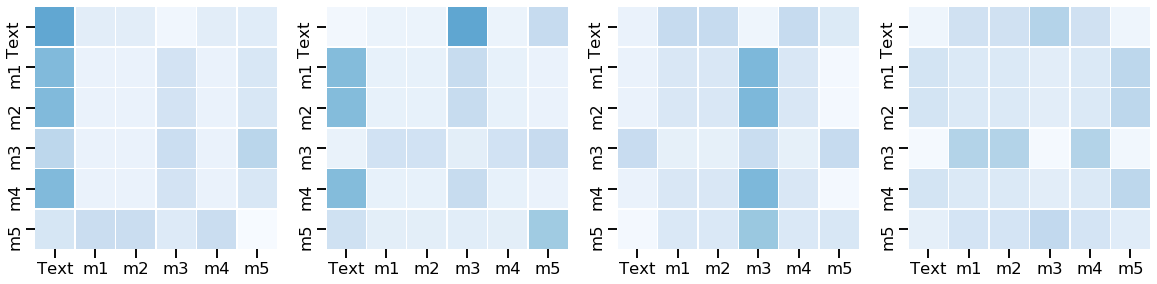

Encoder Layer Attention head 1


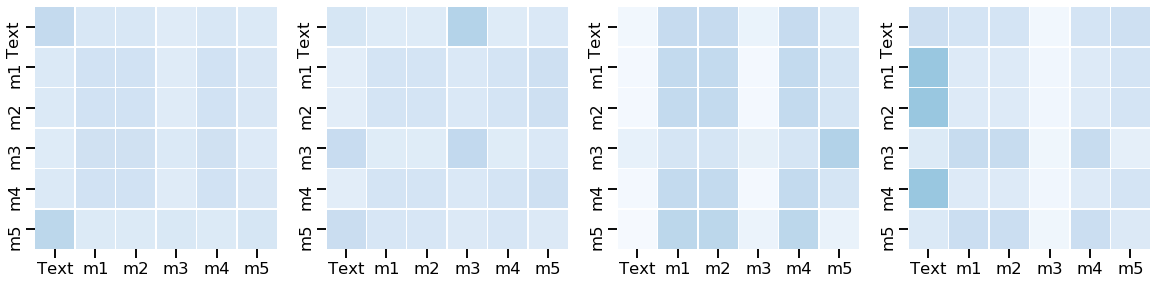

Entrenando Run # 3
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.7490671641791045 	F-macro_val: 0.38642333192431627
Epoch 10 	acc_val: 0.871268656716418 	F-macro_val: 0.48640550894766876
Epoch 20 	acc_val: 0.8502798507462687 	F-macro_val: 0.4934463104047069
Epoch 30 	acc_val: 0.7700559701492538 	F-macro_val: 0.4764273398872991
Epoch 40 	acc_val: 0.8451492537313433 	F-macro_val: 0.4935202453643698
Epoch 50 	acc_val: 0.7947761194029851 	F-macro_val: 0.4829993895738621
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


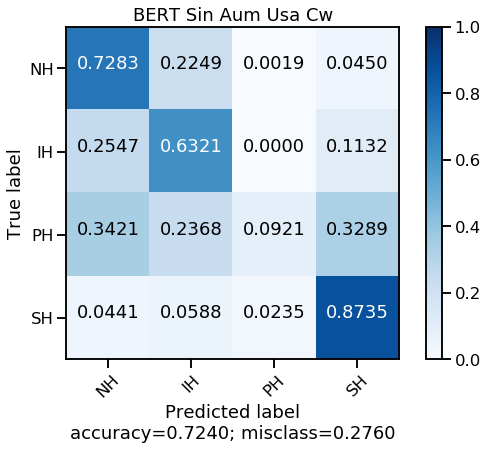

Test_ acc: 0.723975506358926
Test_ f1 none: [0.82257496 0.23467601 0.14893617 0.79624665]
Test_ f1 macro: 0.5006084454799687


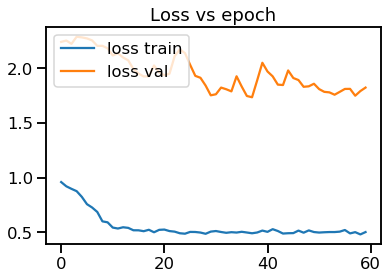

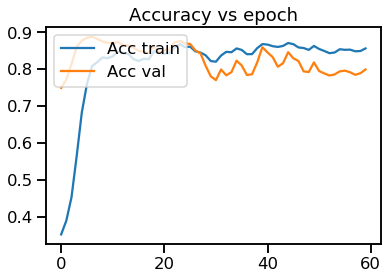

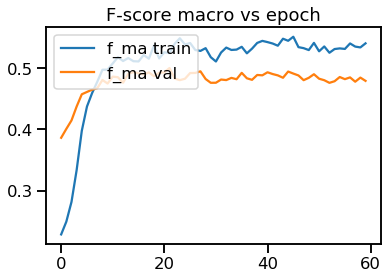

Encoder Layer Attention head 0


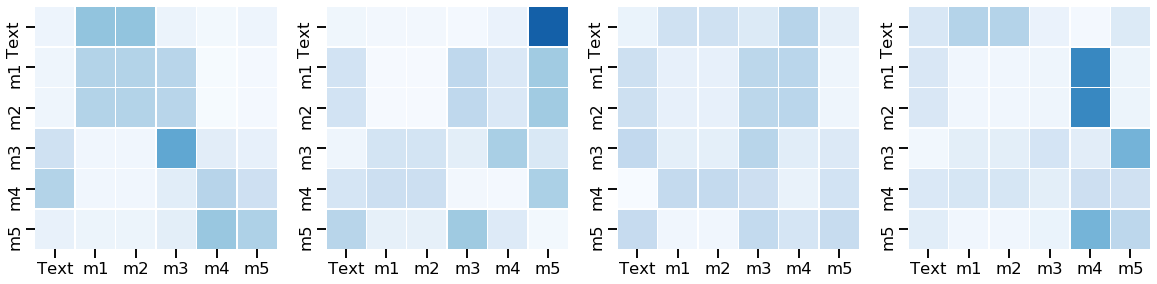

Encoder Layer Attention head 1


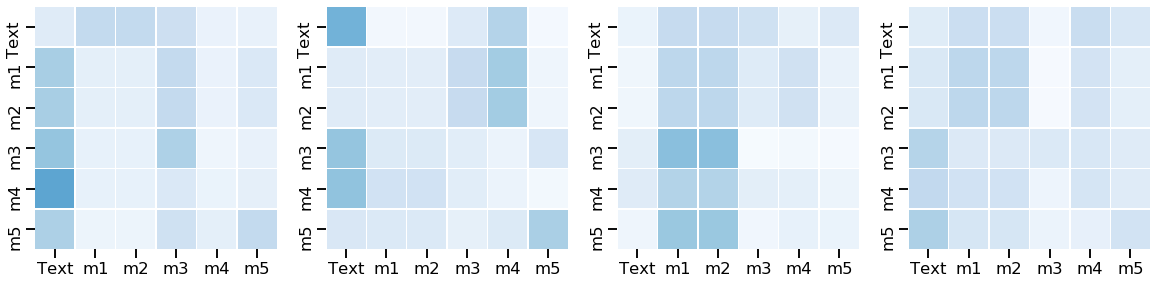

Entrenando Run # 4
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.7014925373134329 	F-macro_val: 0.3692104188834851
Epoch 10 	acc_val: 0.878731343283582 	F-macro_val: 0.4516457683266948
Epoch 20 	acc_val: 0.8782649253731343 	F-macro_val: 0.4538704857717147
Epoch 30 	acc_val: 0.8810634328358209 	F-macro_val: 0.44693604076522964
Epoch 40 	acc_val: 0.882929104477612 	F-macro_val: 0.44744173547638927
Epoch 50 	acc_val: 0.8824626865671642 	F-macro_val: 0.44778476965222896
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


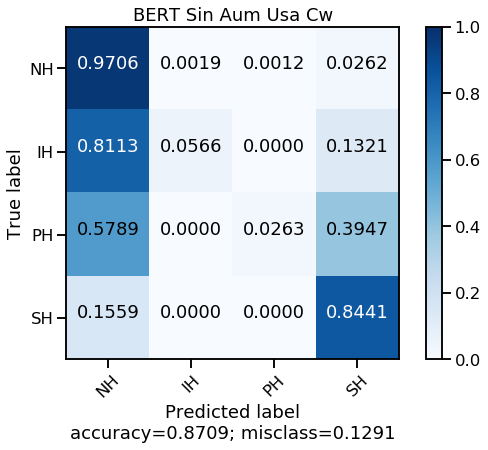

Test_ acc: 0.8709373528026377
Test_ f1 none: [0.93109646 0.10434783 0.05       0.80504909]
Test_ f1 macro: 0.4726233448487685


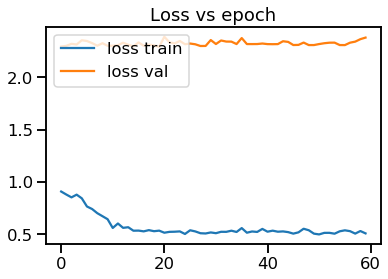

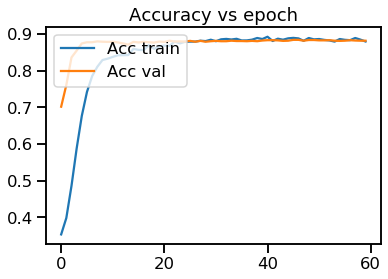

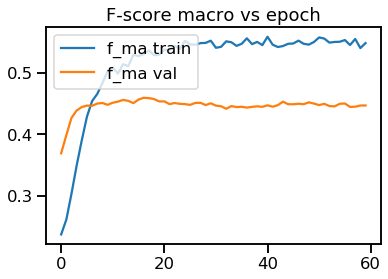

Encoder Layer Attention head 0


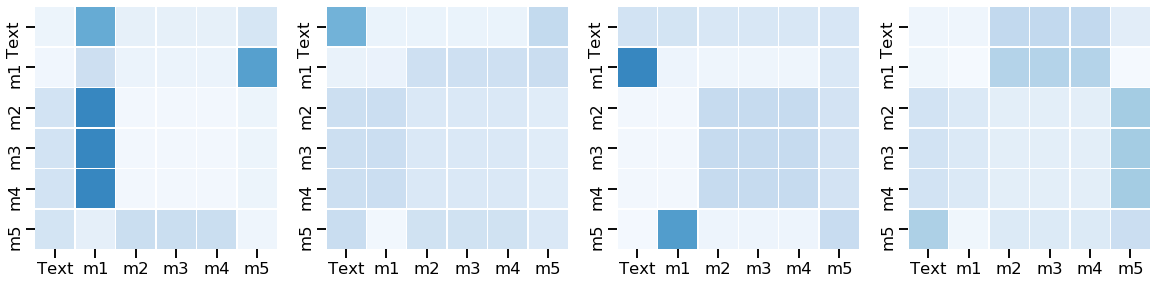

Encoder Layer Attention head 1


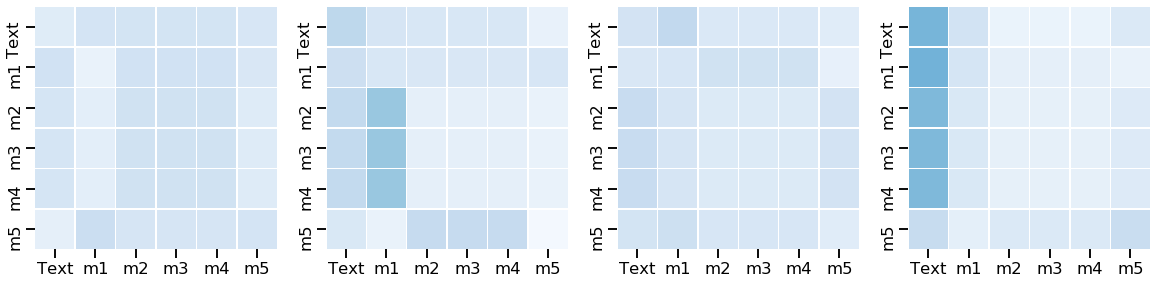

Entrenando Run # 5
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.1021455223880597 	F-macro_val: 0.06926024117605606
Epoch 10 	acc_val: 0.882929104477612 	F-macro_val: 0.4556872991761952
Epoch 20 	acc_val: 0.8819962686567164 	F-macro_val: 0.4632834503950415
Epoch 30 	acc_val: 0.8847947761194029 	F-macro_val: 0.46328416305329967
Epoch 40 	acc_val: 0.8861940298507462 	F-macro_val: 0.4661289039023329
Epoch 50 	acc_val: 0.8871268656716418 	F-macro_val: 0.46071512303735856
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


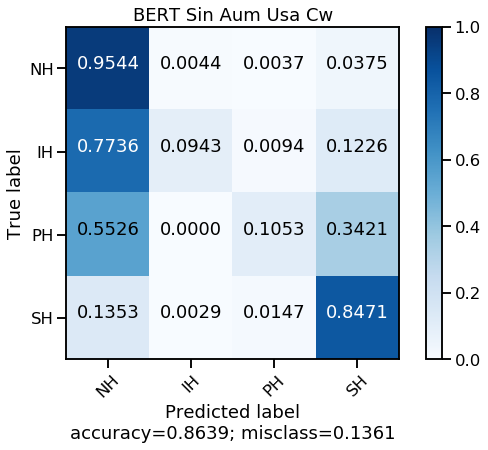

Test_ acc: 0.8638718794159209
Test_ f1 none: [0.92634132 0.16129032 0.16666667 0.79229711]
Test_ f1 macro: 0.511648854053565


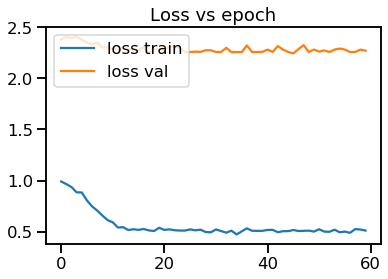

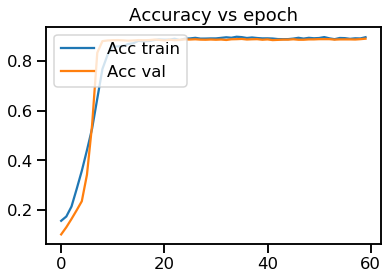

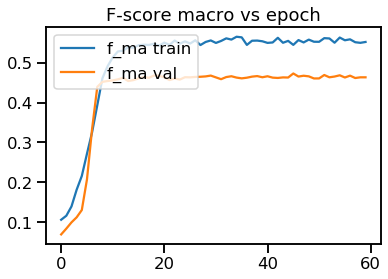

Encoder Layer Attention head 0


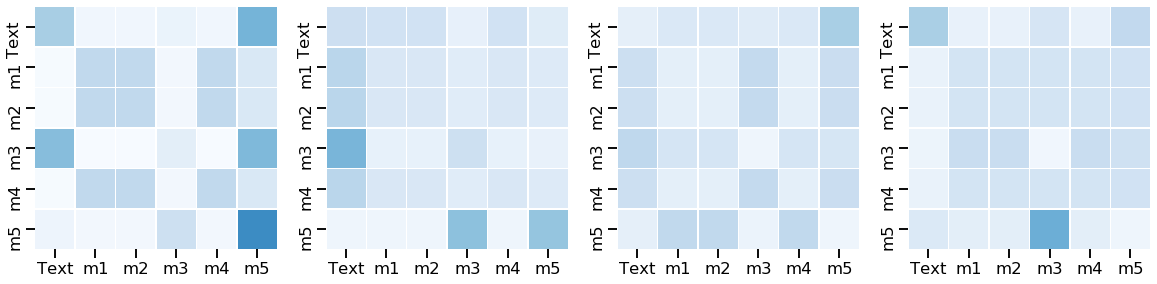

Encoder Layer Attention head 1


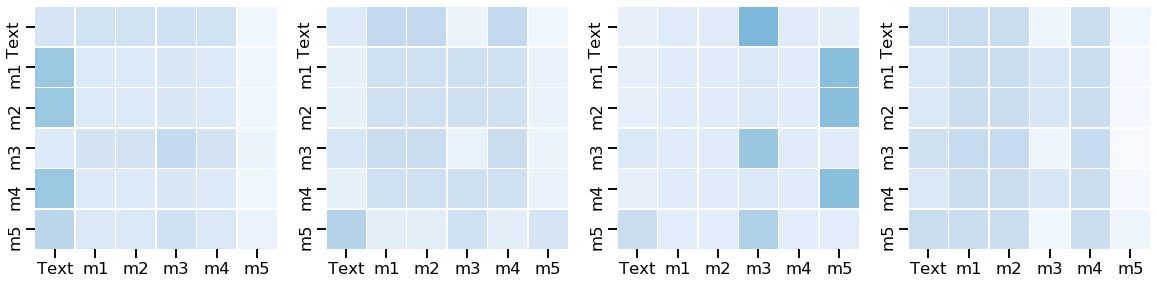

In [17]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.0

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    cnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'_cw/cnn1_'+str(trans)+'-exec_15e.h5')
    cnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'_cw/cnn2_'+str(trans)+'-exec_15e.h5')
    rnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'_cw/rnn1_'+str(trans)+'-exec_8e.h5')
    rnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'_cw/rnn2_'+str(trans)+'-exec_15e.h5')
    rnn3 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'_cw/rnn3_'+str(trans)+'-exec_8e.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    b_dim=768
    
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    
    espacio=[np.ones(b_dim)]
    #Ks=np.load("../../BERTransformer/Orthogonals_768.npy")
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        #ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        encoded_tok, sentence_valid = my_tokenizer(cleaner(tw_tr)[1])  #cleaner: raw, no cleaner:augmented version
                
        final=' '
        frase=[final.join(sentence_valid)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
            
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
      
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 2, 4000,torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-3))

    
    for epoch in range(60):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        hist_train_loss.append(loss_train)
        hist_train_acc.append(acc_train)
        hist_train_fma.append(fma_train)
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
        hist_val_loss.append(loss_val)
        hist_val_acc.append(acc_val)
        hist_val_fma.append(fma_val)
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"BERT Sin Aum Usa Cw")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    plt.plot(hist_train_loss, label='loss train')
    plt.plot(hist_val_loss,label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch")
    plt.show()

    plt.plot(hist_train_acc, label='Acc train')
    plt.plot(hist_val_acc, label='Acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch")
    plt.show()

    plt.plot(hist_train_fma, label='f_ma train')
    plt.plot(hist_val_fma, label='f_ma val')
    plt.legend(loc='upper left')
    plt.title("F-score macro vs epoch")
    plt.show()
    
    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        plt.show()

Acc: 0.8324069712670749
F-score: 0.4982357040642732
(0.0_Use CW) 15-8e NIPS: 0.9026697506902991 0.18858972907323376 0.10324877250409166 0.7984345639894681


Confusion counts
[[7.262e+03 4.680e+02 1.700e+01 2.580e+02]
 [3.390e+02 1.300e+02 3.000e+00 5.800e+01]
 [2.100e+02 2.500e+01 2.400e+01 1.210e+02]
 [2.310e+02 2.900e+01 2.000e+01 1.420e+03]]


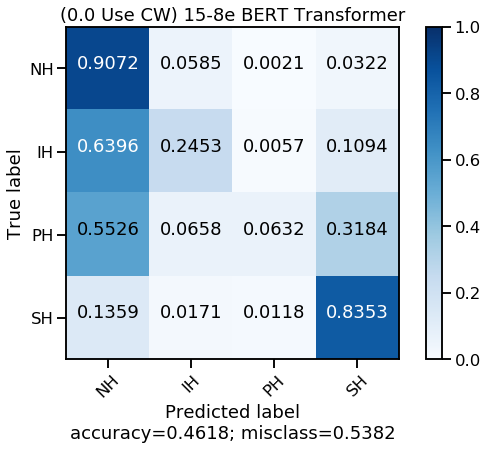

In [18]:
print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.0_Use CW) 15-8e NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)
plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.0 Use CW) 15-8e BERT Transformer", cmap='Blues')

Encoder Layer Attention head Promedio 0


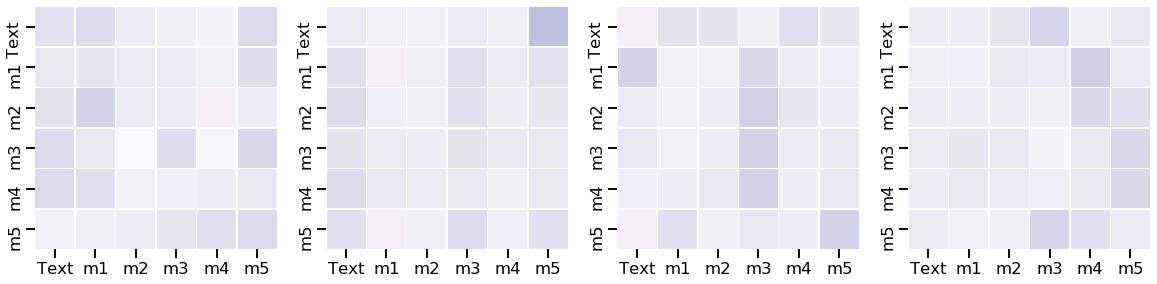

Encoder Layer Attention head Promedio 1


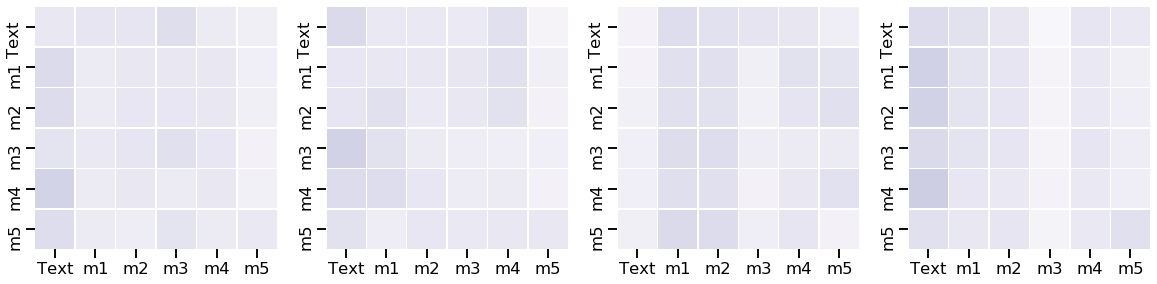

In [19]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Purples", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()
    
for h in range(2):
    for hy in range(4):
        to_mean=dict_attn_enc[str(h)+str(hy)]
        at=np.zeros((6,6))
        for m in to_mean:
            at+=m.numpy() 
        global_attn.append(at/5.)
        
np.save("Attn_SinAum_BERT_UseCW_ECML_60e_24000.npy", global_attn)

## 0.15

In [20]:
val['Tweet'][0]

'RT GLOSSPHOENIX some of y all never watched collected and fucked with the bratz movies and it shows '

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.625 	F-macro_val: 0.22825578722068263
Epoch 10 	acc_val: 0.8833955223880597 	F-macro_val: 0.45006638157463513
Epoch 20 	acc_val: 0.8857276119402985 	F-macro_val: 0.4484977032430008
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


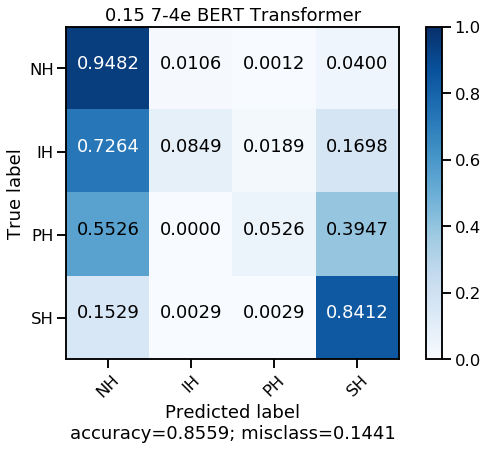

Test_ acc: 0.855864342910975
Test_ f1 none: [0.92279635 0.13533835 0.09411765 0.77506775]
Test_ f1 macro: 0.4818300240461446


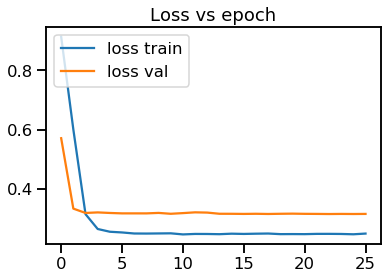

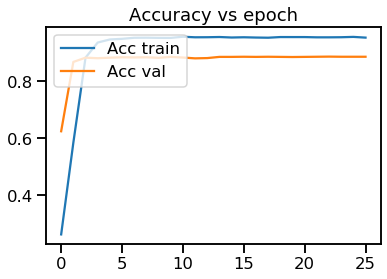

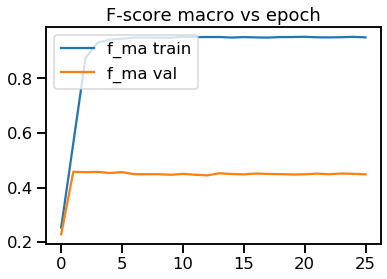

Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.10307835820895522 	F-macro_val: 0.11327346306668737
Epoch 10 	acc_val: 0.8889925373134329 	F-macro_val: 0.45192536463183874
Epoch 20 	acc_val: 0.8899253731343284 	F-macro_val: 0.4506668269027223
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


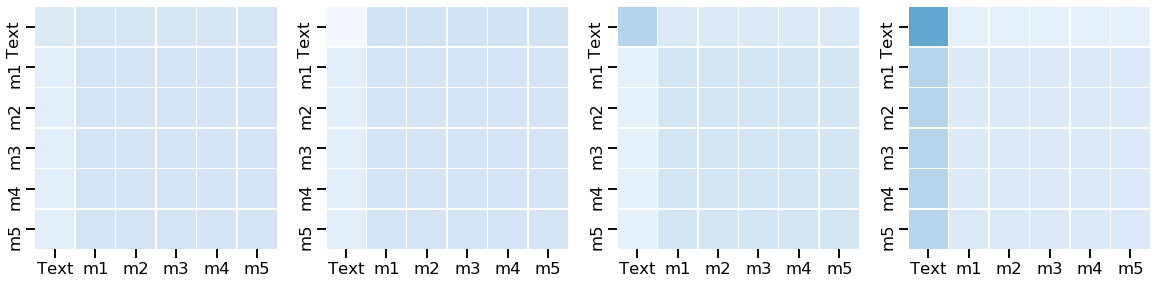

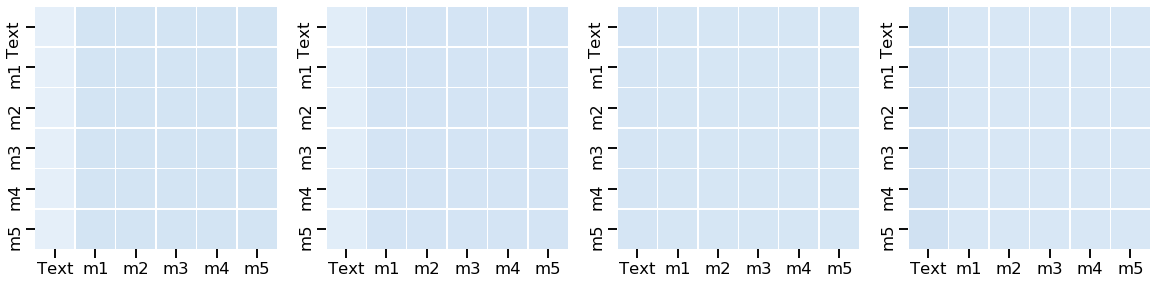

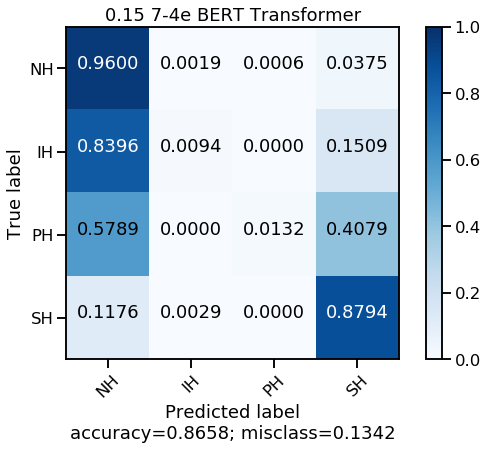

Test_ acc: 0.8657560056523788
Test_ f1 none: [0.92842042 0.01801802 0.02564103 0.80160858]
Test_ f1 macro: 0.44342200988500635


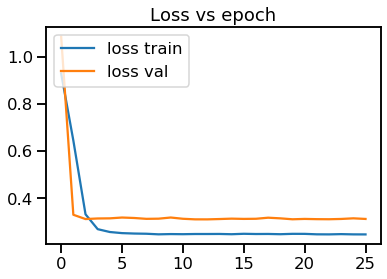

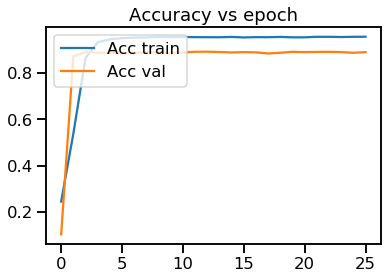

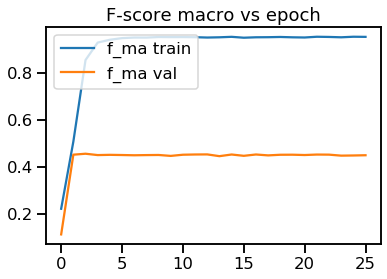

Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.527518656716418 	F-macro_val: 0.30576122854763077
Epoch 10 	acc_val: 0.8964552238805971 	F-macro_val: 0.46421956876680753
Epoch 20 	acc_val: 0.8936567164179104 	F-macro_val: 0.46229134592396826
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


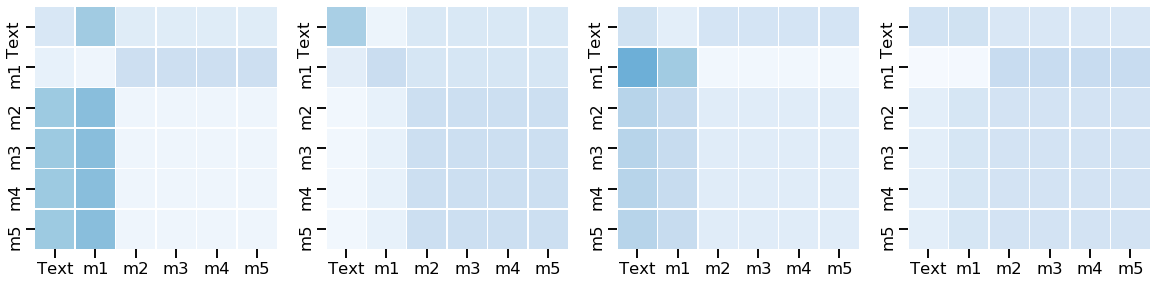

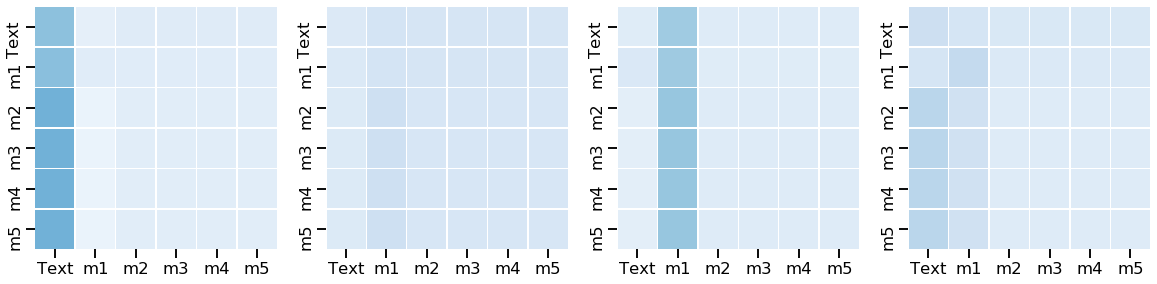

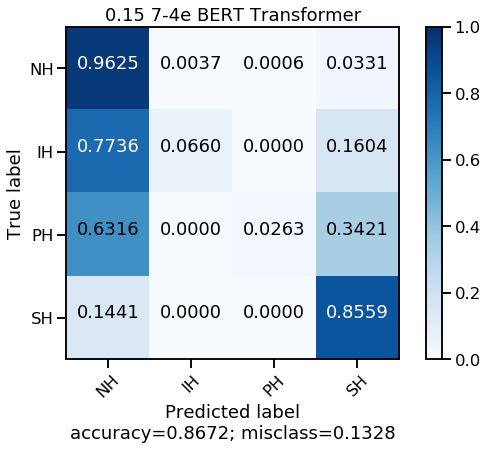

Test_ acc: 0.867169100329722
Test_ f1 none: [0.92803372 0.11764706 0.05063291 0.80055021]
Test_ f1 macro: 0.4742159753312498


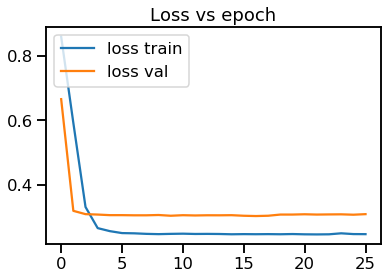

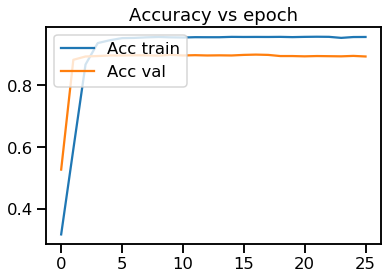

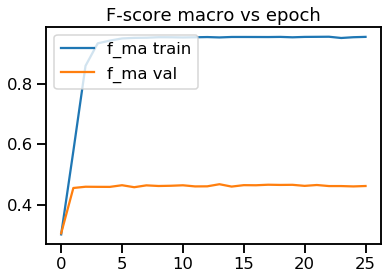

Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.5774253731343284 	F-macro_val: 0.32503195865116596
Epoch 10 	acc_val: 0.8894589552238806 	F-macro_val: 0.4508801104314637
Epoch 20 	acc_val: 0.8899253731343284 	F-macro_val: 0.4512791288870521
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


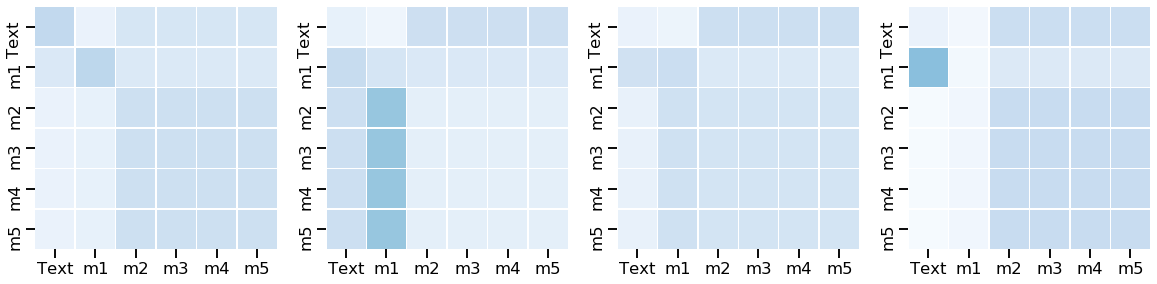

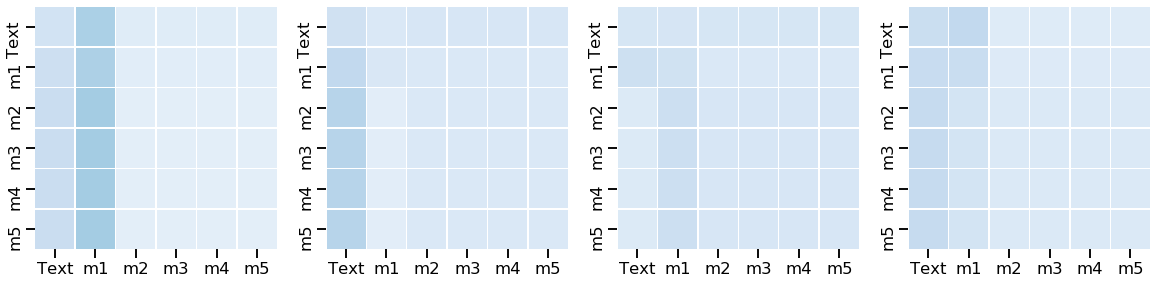

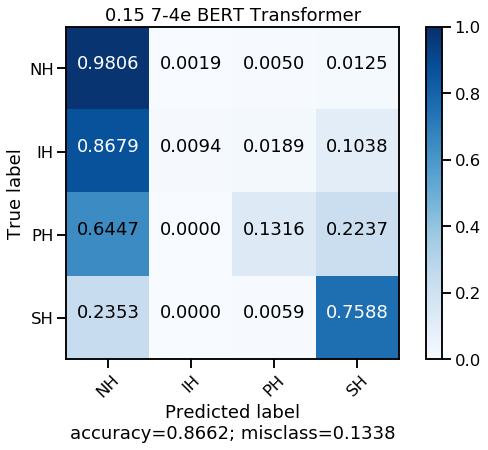

Test_ acc: 0.8662270372114932
Test_ f1 none: [0.92570755 0.01818182 0.20408163 0.79876161]
Test_ f1 macro: 0.4866831519779528


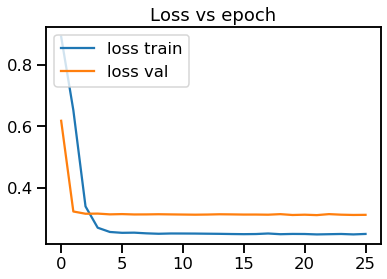

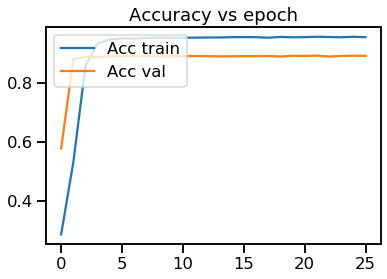

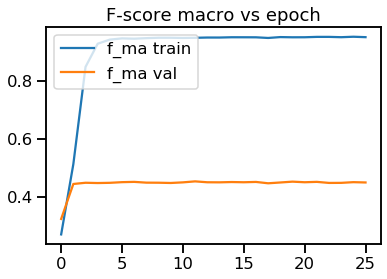

Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.23647388059701493 	F-macro_val: 0.17124888471706878
Epoch 10 	acc_val: 0.8740671641791045 	F-macro_val: 0.44133901954033444
Epoch 20 	acc_val: 0.8801305970149254 	F-macro_val: 0.44444975272603426
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


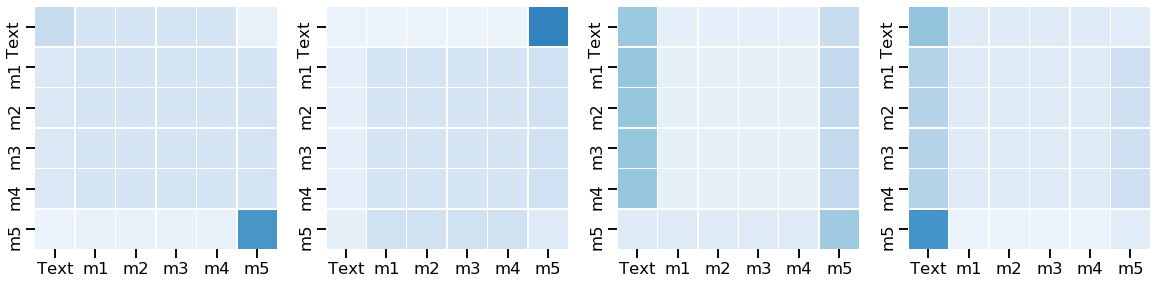

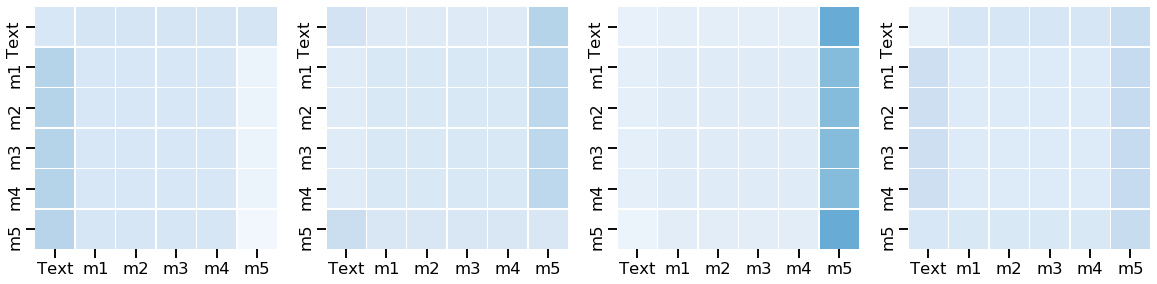

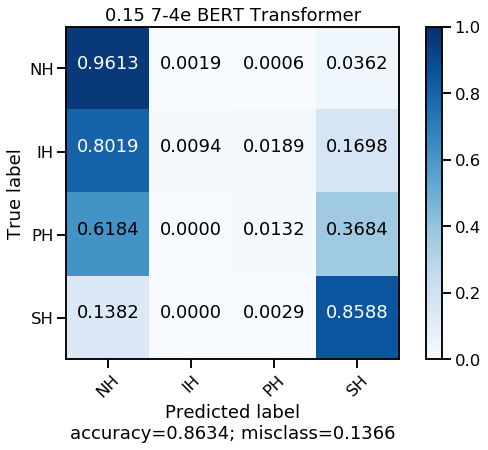

Test_ acc: 0.8634008478568064
Test_ f1 none: [0.92738777 0.01818182 0.02469136 0.79347826]
Test_ f1 macro: 0.44093480111897343


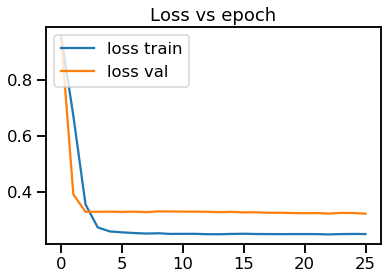

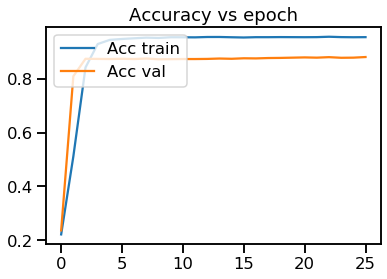

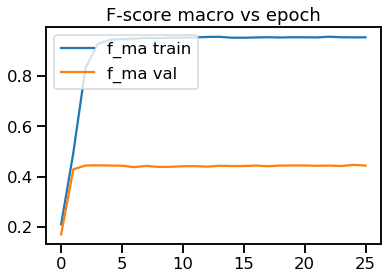

Encoder Layer Attention head 0
Encoder Layer Attention head 1


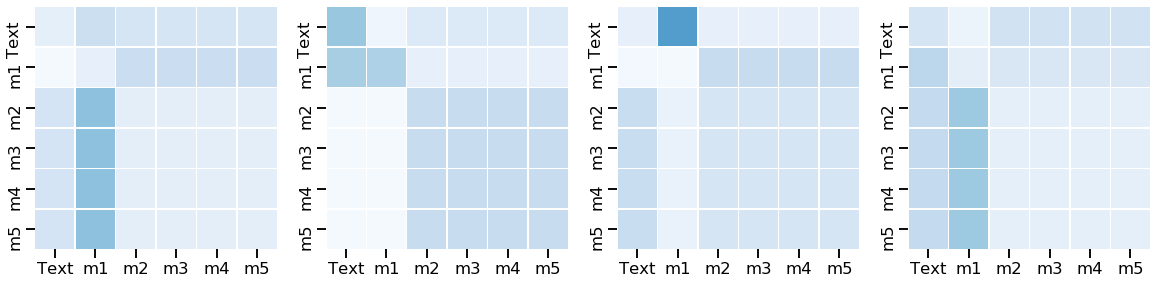

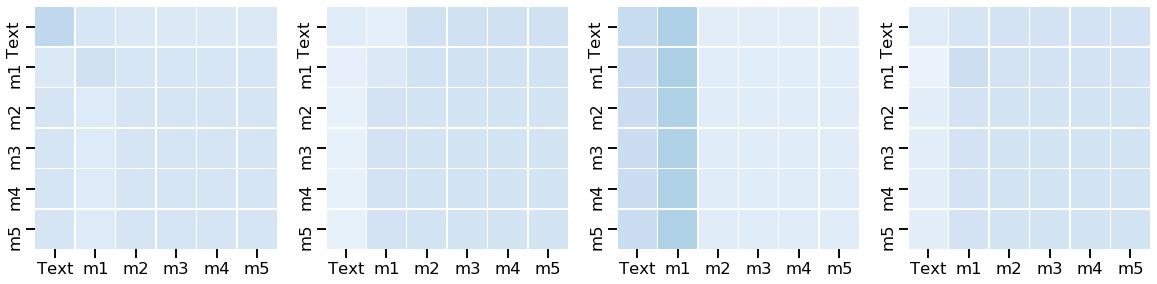

In [21]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.15

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
        
    cnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn1_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    cnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn1_'+str(trans)+'-exec_app1_Top_1_4e.h5')
    rnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn3 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn3_'+str(trans)+'-exec_app1_Top_1_4e.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    b_dim=768
    
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        #tws_train[i]
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]
    
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 2, 4000,torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-3))

    
    for epoch in range(26):  ### 26
        #print ("Learning rate epoch", epoch, "LR", model_opt._rate)
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        hist_train_loss.append(loss_train)
        hist_train_acc.append(acc_train)
        hist_train_fma.append(fma_train)
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
        hist_val_loss.append(loss_val)
        hist_val_acc.append(acc_val)
        hist_val_fma.append(fma_val)
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"0.15 7-4e BERT Transformer")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 
    
    plt.plot(hist_train_loss, label='loss train')
    plt.plot(hist_val_loss,label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch")
    plt.show()

    plt.plot(hist_train_acc, label='Acc train')
    plt.plot(hist_val_acc, label='Acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch")
    plt.show()

    plt.plot(hist_train_fma, label='f_ma train')
    plt.plot(hist_val_fma, label='f_ma val')
    plt.legend(loc='upper left')
    plt.title("F-score macro vs epoch")
    plt.show()

    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        #plt.show()

con 7 y 4 epochs...

Acc: 0.863683466792275
F-score: 0.4654171924718654
(0.15) NIPS: 0.9264691617454839 0.06147341181396909 0.07983291495400135 0.7938932813740074


Confusion counts
[[7.705e+03 3.200e+01 1.300e+01 2.550e+02]
 [4.250e+02 1.900e+01 6.000e+00 8.000e+01]
 [2.300e+02 0.000e+00 1.800e+01 1.320e+02]
 [2.680e+02 2.000e+00 4.000e+00 1.426e+03]]


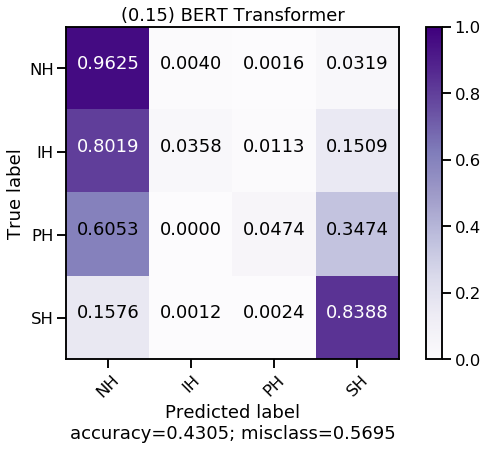

In [22]:
print ("con 7 y 4 epochs...\n")

print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])
print ("(0.15) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
print (m_temp)

plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.15) BERT Transformer", cmap='Purples')



[0.15] Encoder Layer Attention head Promedio 0


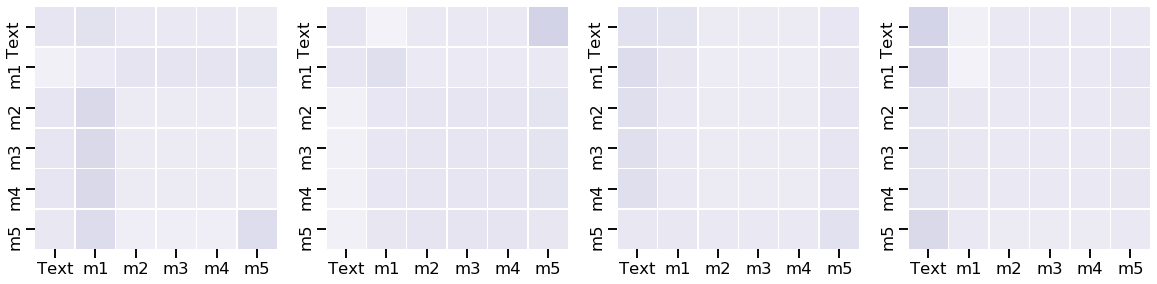

[0.15] Encoder Layer Attention head Promedio 1


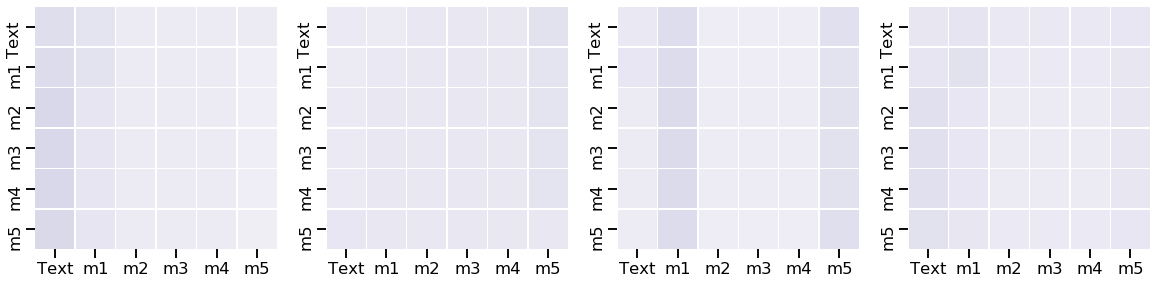

In [23]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("[0.15] Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Purples", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()
    
for h in range(2):
    for hy in range(4):
        to_mean=dict_attn_enc[str(h)+str(hy)]
        at=np.zeros((6,6))
        for m in to_mean:
            at+=m.numpy()
        global_attn.append(at/5.)
        
np.save("Attn_BERT_15_ECML_26e_74_24000.npy", global_attn)

### 0.5

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.5368470149253731 	F-macro_val: 0.2727295910170636
Epoch 10 	acc_val: 0.8782649253731343 	F-macro_val: 0.44426181036697465
Epoch 20 	acc_val: 0.8745335820895522 	F-macro_val: 0.44074960380739536
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


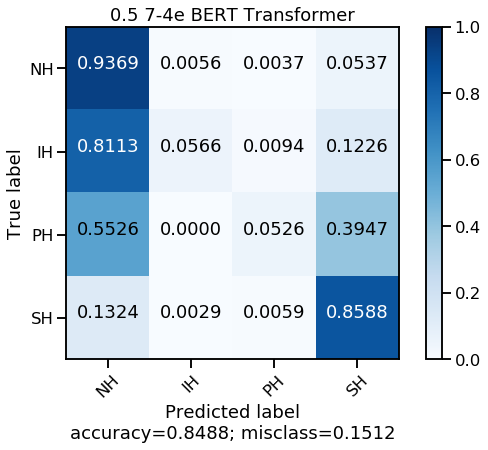

Test_ acc: 0.8487988695242581
Test_ f1 none: [0.91631032 0.09836066 0.08988764 0.7674113 ]
Test_ f1 macro: 0.4679924802174916
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.40578358208955223 	F-macro_val: 0.2754546135081362
Epoch 10 	acc_val: 0.8726679104477612 	F-macro_val: 0.45164123707391507
Epoch 20 	acc_val: 0.8745335820895522 	F-macro_val: 0.4459173524613397
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


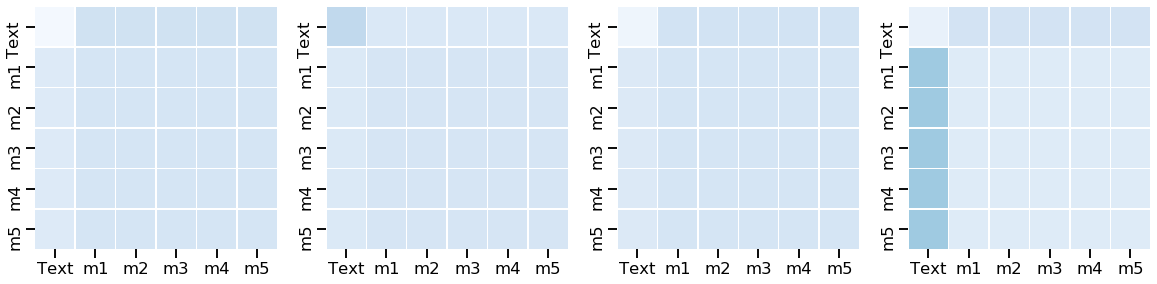

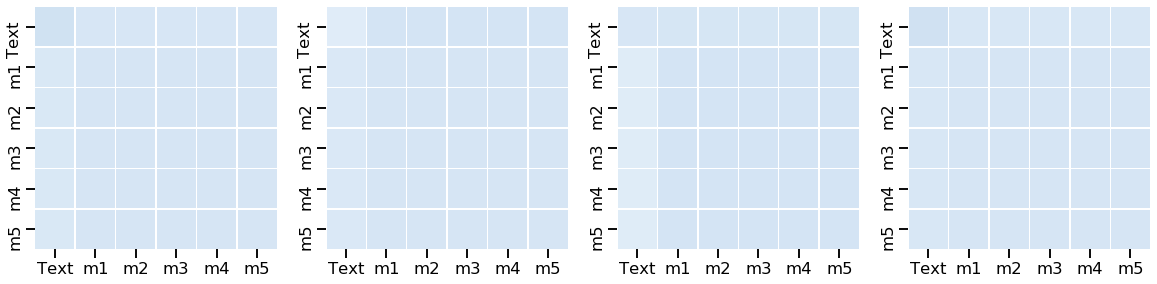

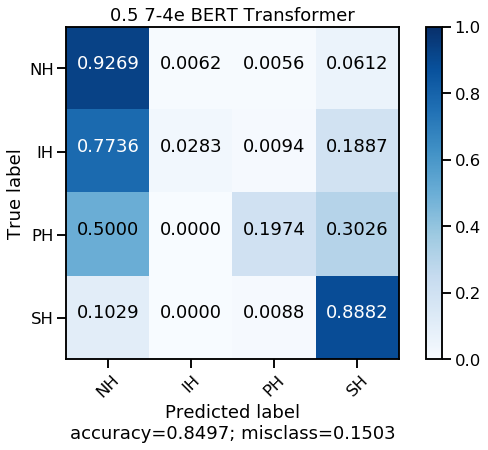

Test_ acc: 0.8497409326424871
Test_ f1 none: [0.91604938 0.05042017 0.28846154 0.77139208]
Test_ f1 macro: 0.506580792745431
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.7583955223880597 	F-macro_val: 0.39251983356402936
Epoch 10 	acc_val: 0.8810634328358209 	F-macro_val: 0.4482289249658205
Epoch 20 	acc_val: 0.8791977611940298 	F-macro_val: 0.44617521783179925
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


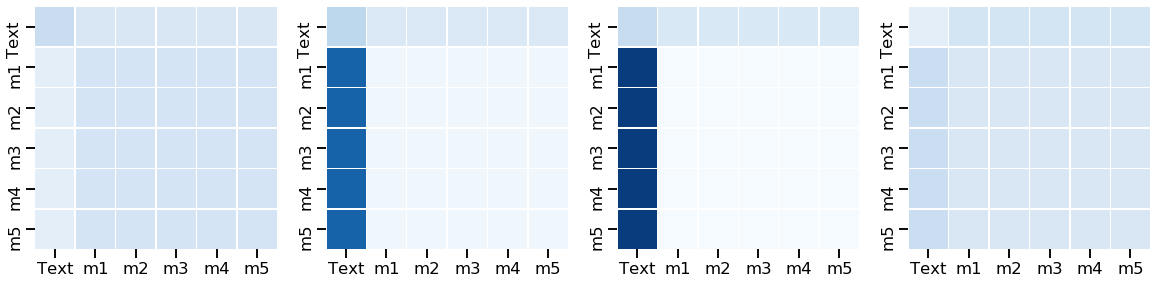

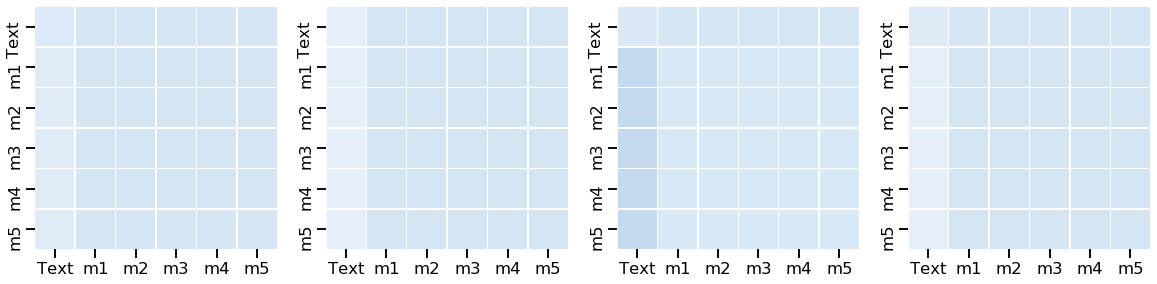

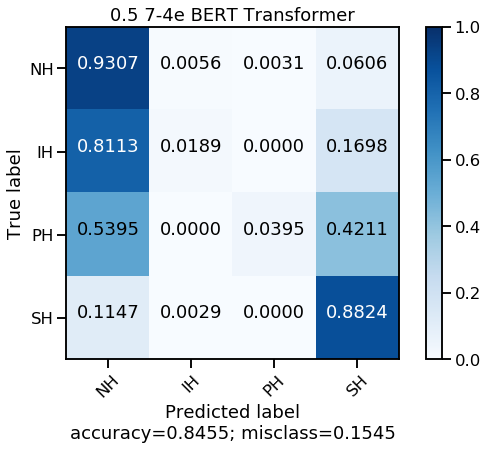

Test_ acc: 0.8455016486104568
Test_ f1 none: [0.91495241 0.03389831 0.07142857 0.76238882]
Test_ f1 macro: 0.4456670262510196
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.5237873134328358 	F-macro_val: 0.29814444710685395
Epoch 10 	acc_val: 0.8815298507462687 	F-macro_val: 0.4512710334957579
Epoch 20 	acc_val: 0.8768656716417911 	F-macro_val: 0.4547611907591691
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


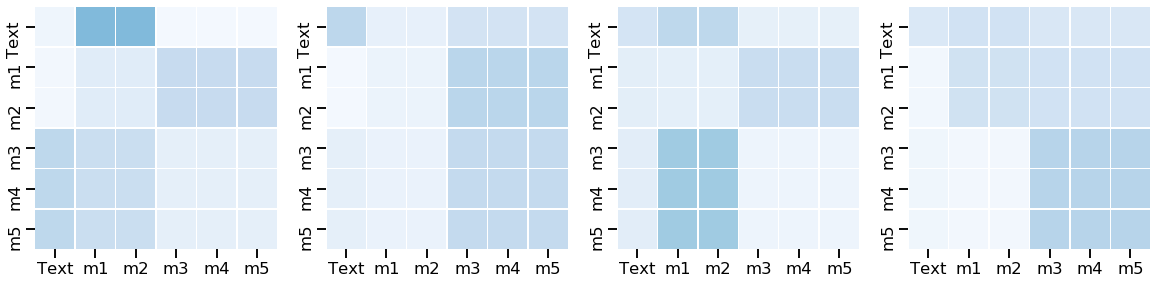

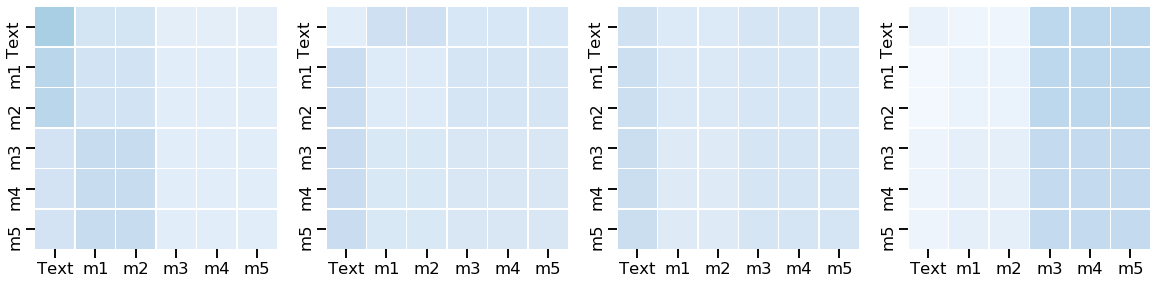

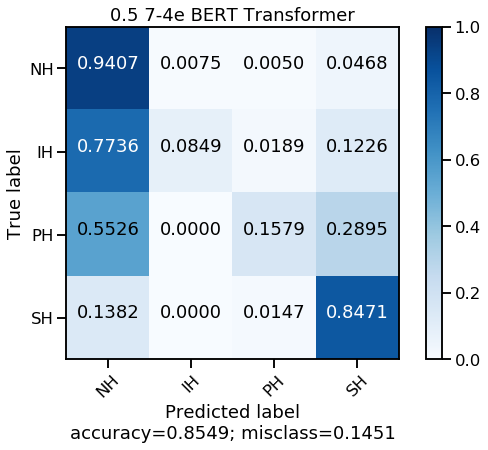

Test_ acc: 0.8549222797927462
Test_ f1 none: [0.91885296 0.14173228 0.23300971 0.7804878 ]
Test_ f1 macro: 0.5185206890504738
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.5186567164179104 	F-macro_val: 0.36520838661544835
Epoch 10 	acc_val: 0.8833955223880597 	F-macro_val: 0.4451808862834054
Epoch 20 	acc_val: 0.8833955223880597 	F-macro_val: 0.44775396256436545
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


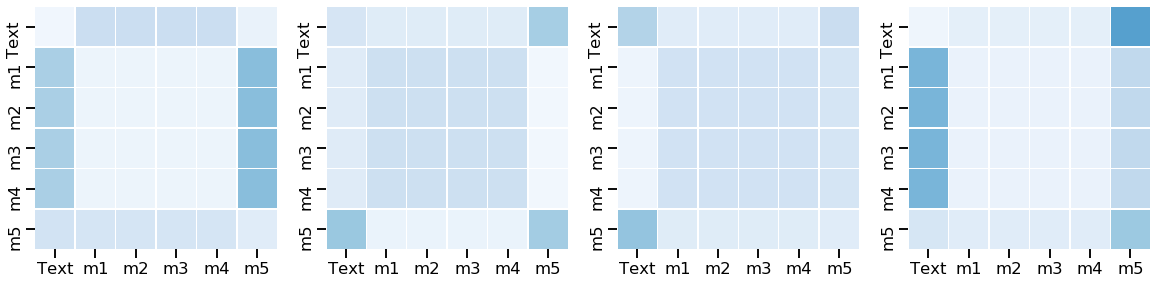

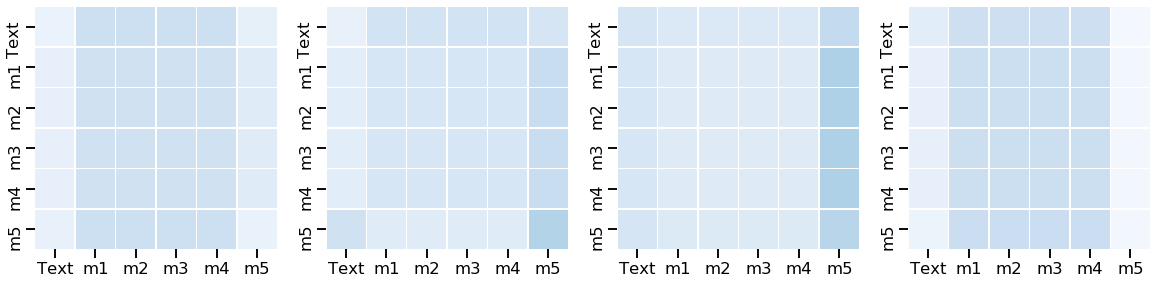

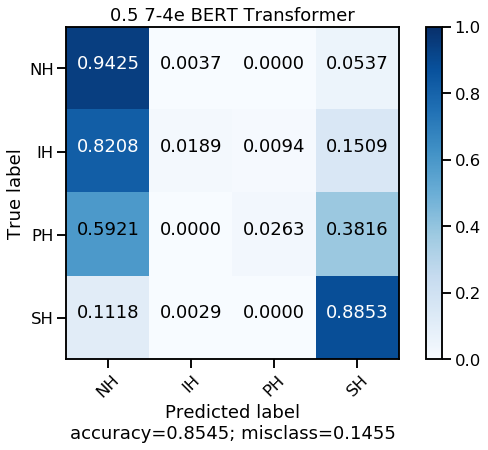

Test_ acc: 0.8544512482336316
Test_ f1 none: [0.92012195 0.03478261 0.05063291 0.77979275]
Test_ f1 macro: 0.4463325543553898
Encoder Layer Attention head 0
Encoder Layer Attention head 1


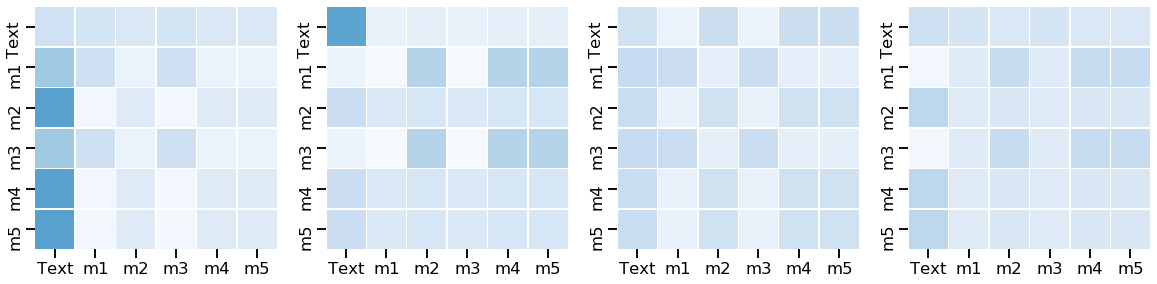

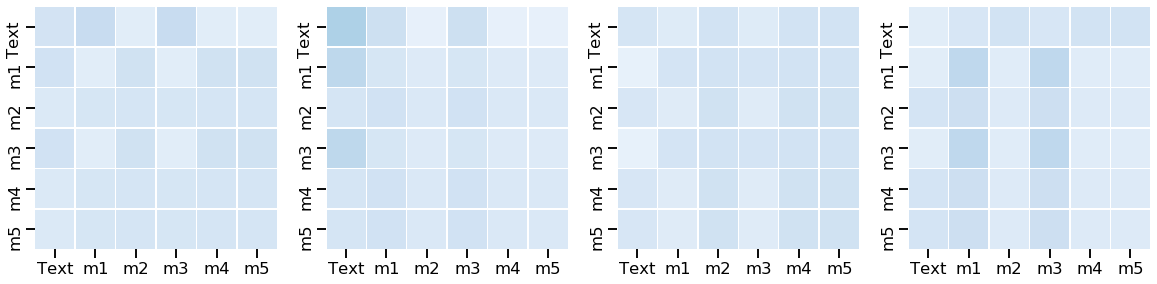

In [24]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.5

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
        
    cnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn1_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    cnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn1_'+str(trans)+'-exec_app1_Top_1_4e.h5')
    rnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn3 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn3_'+str(trans)+'-exec_app1_Top_1_4e.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    b_dim=768
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 2, 4000,torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-3))

    
    for epoch in range(26): # 26
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"0.5 7-4e BERT Transformer")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        #plt.show()

con 7 y 4 epochs...

Acc: 0.8506829957607159
F-score: 0.47701870852396117
(0.5) NIPS: 0.9172574054026775 0.07183880420997933 0.14668407409396347 0.7722945503892242


Confusion counts
[[7.489e+03 4.600e+01 2.800e+01 4.420e+02]
 [4.230e+02 2.200e+01 5.000e+00 8.000e+01]
 [2.080e+02 0.000e+00 3.600e+01 1.360e+02]
 [2.040e+02 3.000e+00 1.000e+01 1.483e+03]]


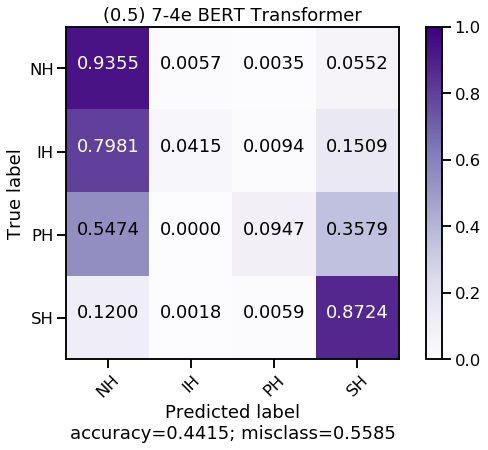

In [25]:
print ("con 7 y 4 epochs...\n")

print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.5) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
print (m_temp)

plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.5) 7-4e BERT Transformer", cmap='Purples')

[0.5] Encoder Layer Attention head Promedio 0


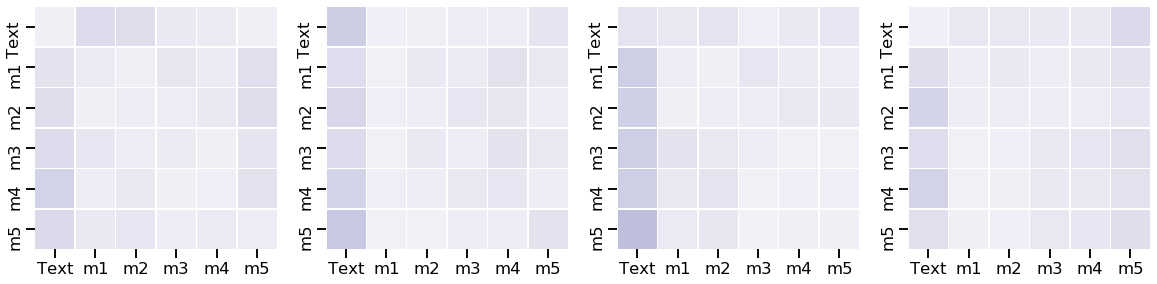

[0.5] Encoder Layer Attention head Promedio 1


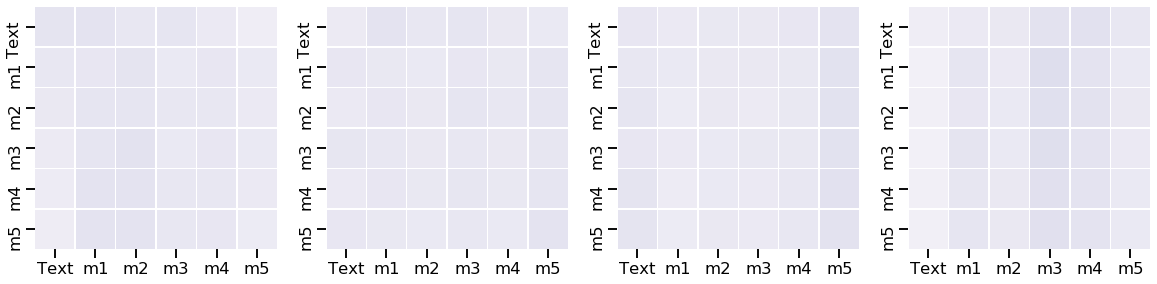

In [26]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("[0.5] Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Purples", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()
    
for h in range(2):
    for hy in range(4):
        to_mean=dict_attn_enc[str(h)+str(hy)]
        at=np.zeros((6,6))
        for m in to_mean:
            at+=m.numpy()
        global_attn.append(at/5.)
        
np.save("Attn_BERT_50_ECML_26e_74_24000.npy", global_attn)

### 0.85

Entrenando Run # 1
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.1609141791044776 	F-macro_val: 0.16621367094696826
Epoch 10 	acc_val: 0.8736007462686567 	F-macro_val: 0.44743198965889874
Epoch 20 	acc_val: 0.8754664179104478 	F-macro_val: 0.44378568440440275
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


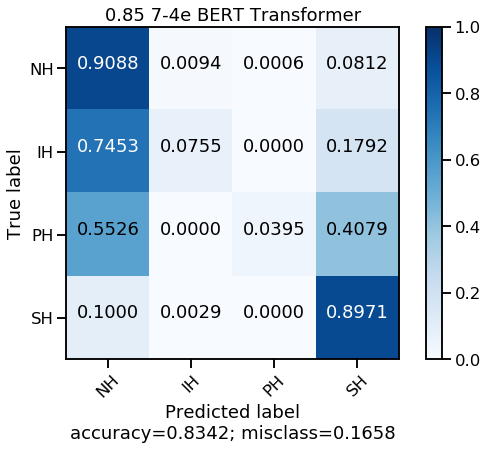

Test_ acc: 0.8341968911917098
Test_ f1 none: [0.90625973 0.12307692 0.075      0.73939394]
Test_ f1 macro: 0.4609326486603814
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 2
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.3180970149253731 	F-macro_val: 0.1775654144632725
Epoch 10 	acc_val: 0.867070895522388 	F-macro_val: 0.44368498841932
Epoch 20 	acc_val: 0.8815298507462687 	F-macro_val: 0.4507989876083082
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


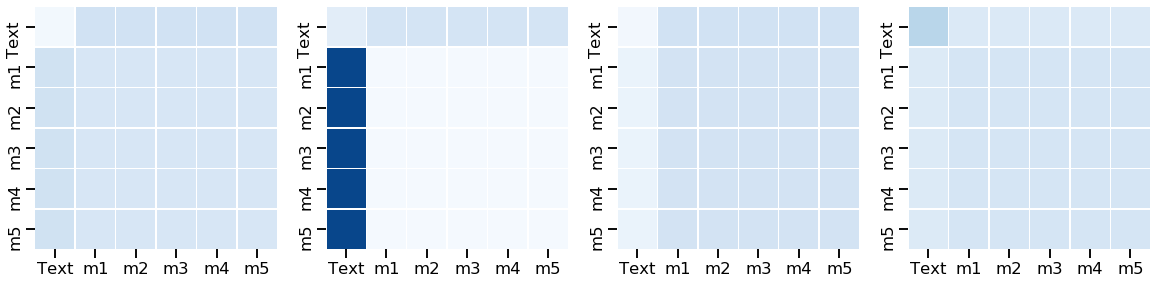

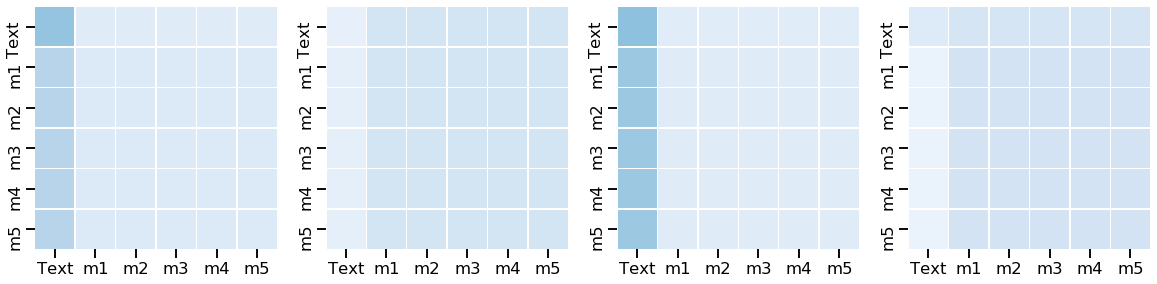

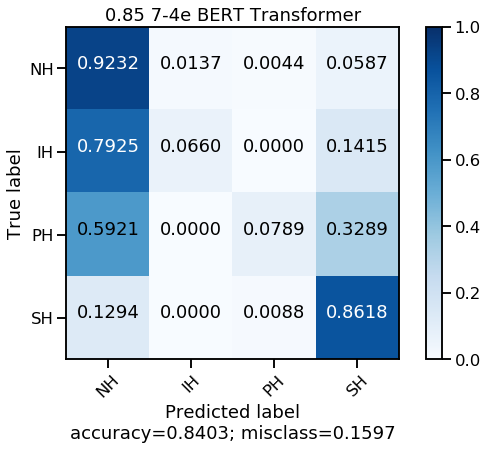

Test_ acc: 0.8403203014601979
Test_ f1 none: [0.90897909 0.1037037  0.13043478 0.76401565]
Test_ f1 macro: 0.4767833053687187
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 3
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.7486007462686567 	F-macro_val: 0.3718536088624034
Epoch 10 	acc_val: 0.867070895522388 	F-macro_val: 0.44205851970358107
Epoch 20 	acc_val: 0.8675373134328358 	F-macro_val: 0.43906882544902154
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


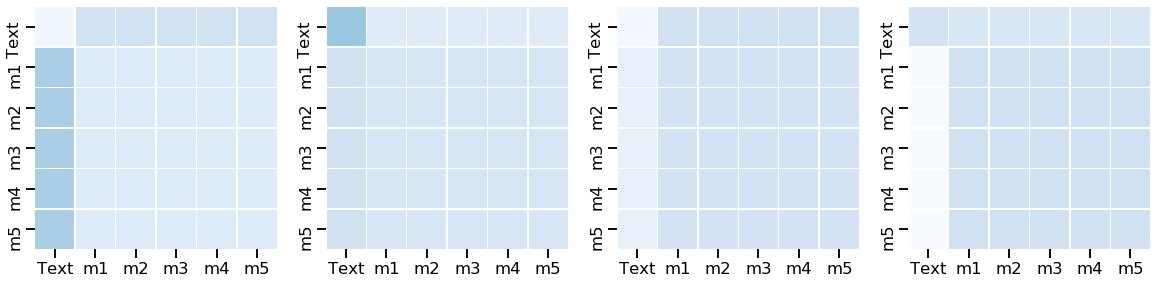

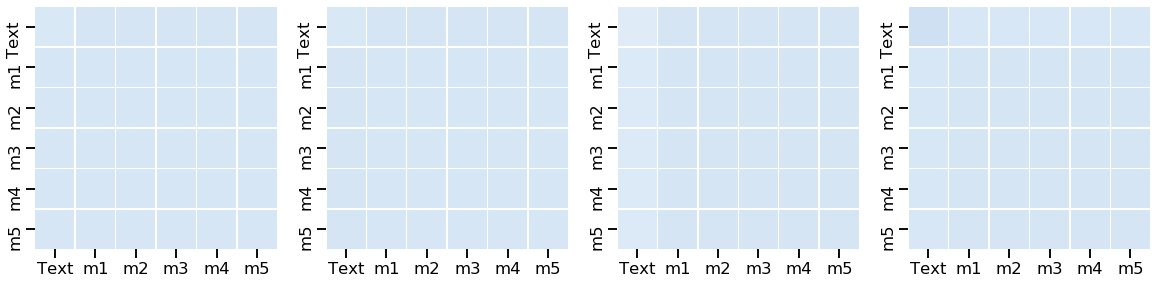

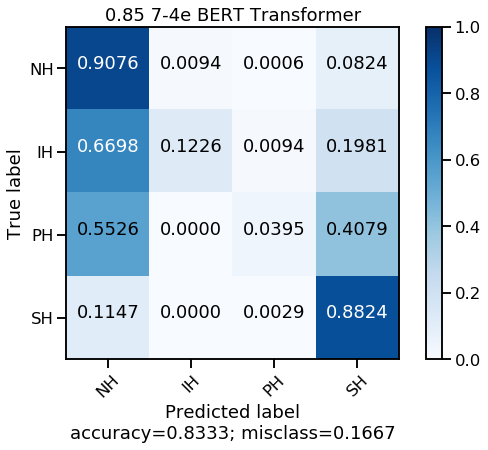

Test_ acc: 0.833254828073481
Test_ f1 none: [0.90642545 0.19402985 0.07317073 0.72815534]
Test_ f1 macro: 0.47544534363409796
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 4
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.1142723880597015 	F-macro_val: 0.0768781836667268
Epoch 10 	acc_val: 0.8694029850746269 	F-macro_val: 0.4346104266363309
Epoch 20 	acc_val: 0.8722014925373134 	F-macro_val: 0.43530668358308516
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


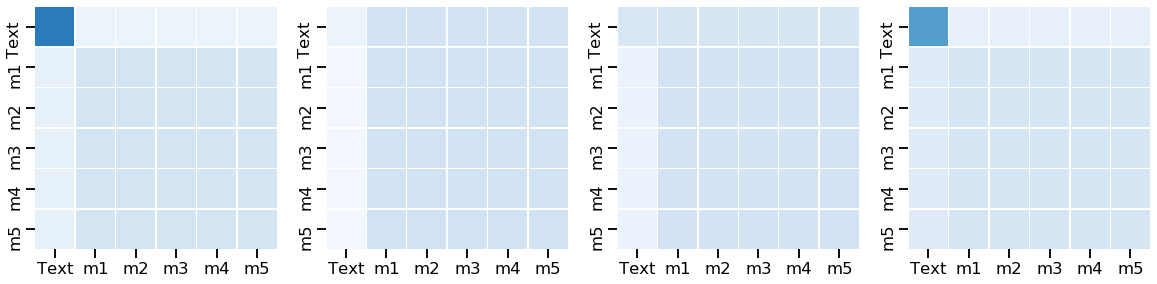

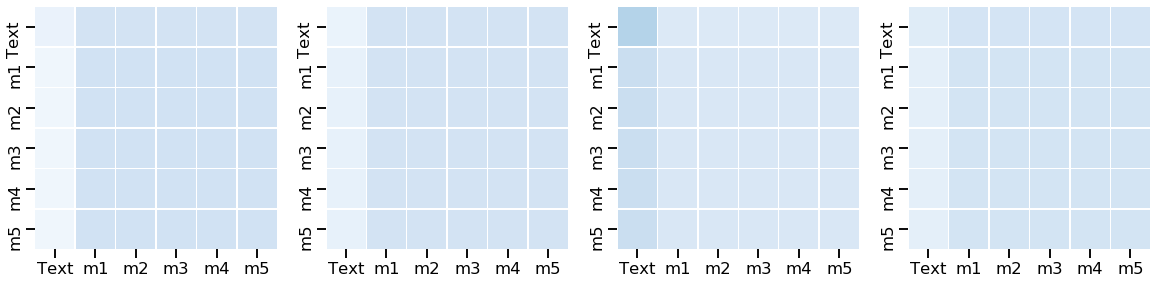

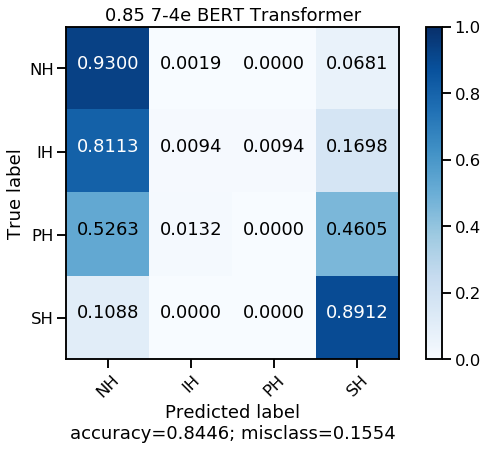

Test_ acc: 0.844559585492228
Test_ f1 none: [0.91546265 0.01801802 0.         0.75279503]
Test_ f1 macro: 0.4215689247338962
Encoder Layer Attention head 0
Encoder Layer Attention head 1
Entrenando Run # 5
Pesos de clases: [1. 1. 1. 1.]
agregando predicciones Train
agregando predicciones Val
agregando predicciones Test
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.7406716417910447 	F-macro_val: 0.34557442441669484
Epoch 10 	acc_val: 0.8843283582089553 	F-macro_val: 0.44151111786535263
Epoch 20 	acc_val: 0.886660447761194 	F-macro_val: 0.44553911126809065
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


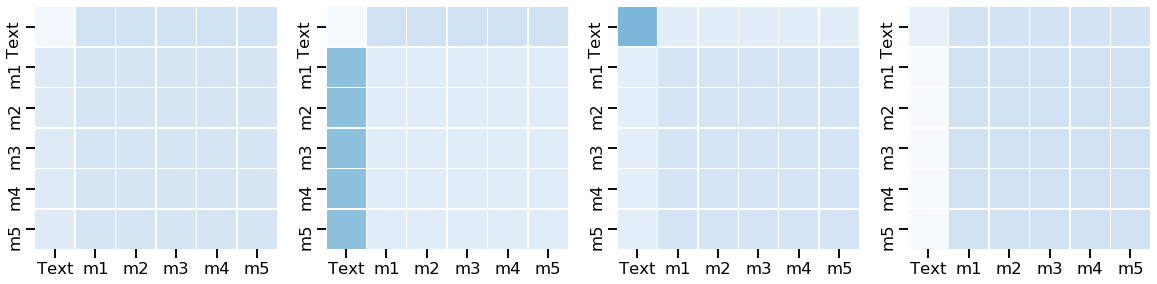

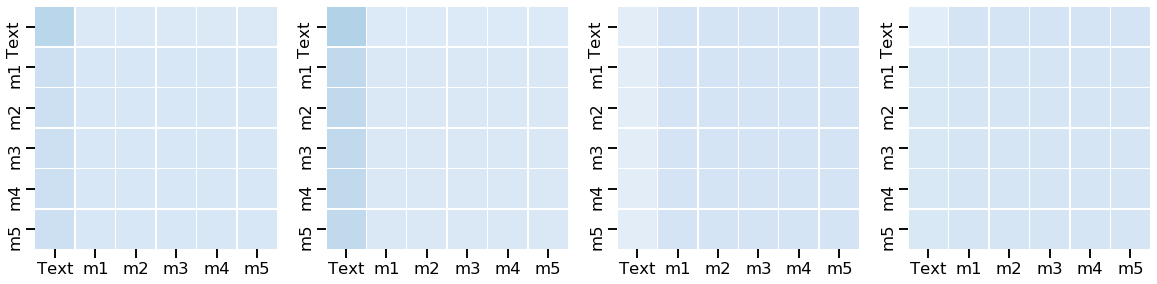

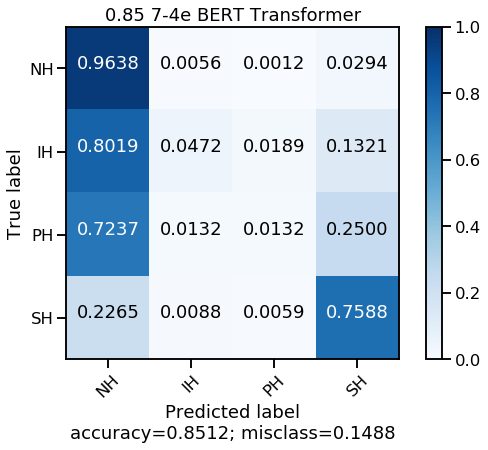

Test_ acc: 0.8511540273198305
Test_ f1 none: [0.91817911 0.08064516 0.02409639 0.76106195]
Test_ f1 macro: 0.44599565177356637
Encoder Layer Attention head 0
Encoder Layer Attention head 1


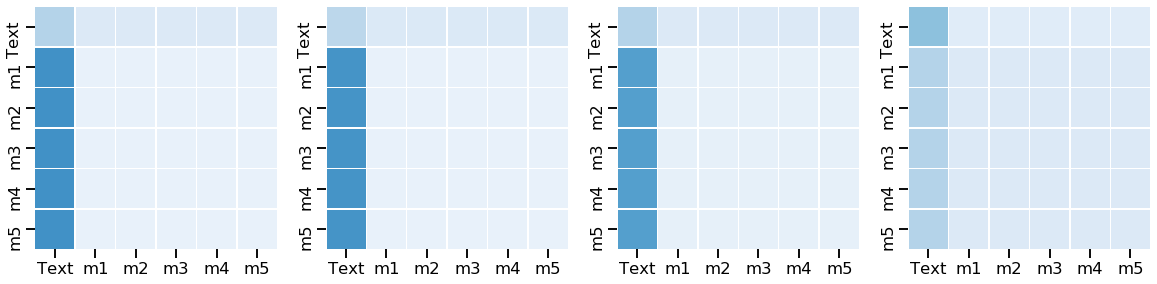

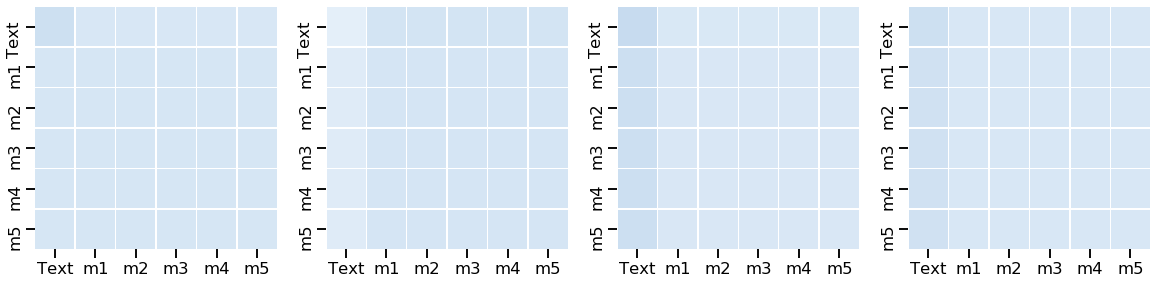

In [27]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
global_attn=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}
  
prob=0.85

for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    macro_augmented= np.load('../new_glove_augmented/harassment/Aumento_'+str(trans)+'-run_'+str(prob)+'_app1_Top1.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
        
    cnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn1_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    cnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/cnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn1 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn1_'+str(trans)+'-exec_app1_Top_1_4e.h5')
    rnn2 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn2_'+str(trans)+'-exec_app1_Top_1_7e.h5')
    rnn3 = load_model('../new_glove_augmented/harassment_baselines/'+str(prob)+'/rnn3_'+str(trans)+'-exec_app1_Top_1_4e.h5')

    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    b_dim=768
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    print ("agregando predicciones Train")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    print ("agregando predicciones Val")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    print ("agregando predicciones Test")
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
    
    
    espacio=[np.ones(b_dim)]
    Ks= ortho_group.rvs(dim=b_dim)
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    index_embeddings=[0,1,2,3,4]
    lab_str_embeddings=['','','','','']

    for i in range(len(sentences)):
        ide=ids_train[i]
        tw_tr=tws_train[i]
        clase=dict_cl[labels_train[i]]
        
        final=' '
        frase=[final.join(tw_tr)]
        try: 
            vector= bc.encode(frase)[0]  
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)
        
        index_embeddings.append(i+5)
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)
    
    
    objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
    objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
    lab_val=val['Label']
    lab_test=test['Label']
    tw_val=val['Tweet']
    tw_test=test['Tweet']
    llaves=np.concatenate([objs_val,objs_test])
    clases=np.concatenate([lab_val,lab_test])
    sent_all=np.concatenate([tw_val,tw_test])
    
       
    for num in range(len(llaves)):
        i=llaves[num]
        clase=clases[num]
        tw_tr=sent_all[num]
        #vector=np.load("../BaS_Original/Original/"+str(i)+".npy")
        encoded_tok, tokens_valid =my_tokenizer(cleaner(tw_tr)[1])
    
        final=' '
        frase=[final.join(tokens_valid)]
        try: 
            vector= bc.encode(frase)[0]    
            #norm=np.linalg.norm(vector)
            final_bert= vector #/ norm
        except: 
            final_bert= np.zeros(b_dim)

        index_embeddings.append(num+5+train.shape[0])
        lab_str_embeddings.append(clase)
        K_list_ext.append(final_bert)

    K_list_new= np.asarray(K_list_ext, dtype='float32')
    
    ###################################### TRANSFORMER ###############################
    V = 4
    pesos = torch.from_numpy(class_weights).float()
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=b_dim, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 2, 4000,torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-3))

    
    for epoch in range(26):   # 26
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
        
        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        if epoch%10==0:
            print ("Epoch",epoch, "\tacc_val:",acc_val.numpy(), "\tF-macro_val:",fma_val.numpy())
    
    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)
    
    glo_acc=accuracy_score(etiq_t, predicciones[:-21])
    glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

    glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

    plot_confusion_matrix(glo_cm,["NH","IH","PH","SH"],"0.85 7-4e BERT Transformer")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)
    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        #plt.show()

con 7 y 4 epochs...

Acc: 0.8406971267074894
F-score: 0.45614517483413214
(0.85) NIPS: 0.9110612074918654 0.10389473136704722 0.060540379971636284 0.7490843805059795


Confusion counts
[[7.418e+03 6.400e+01 1.100e+01 5.120e+02]
 [4.050e+02 3.400e+01 4.000e+00 8.700e+01]
 [2.240e+02 2.000e+00 1.300e+01 1.410e+02]
 [2.310e+02 4.000e+00 6.000e+00 1.459e+03]]


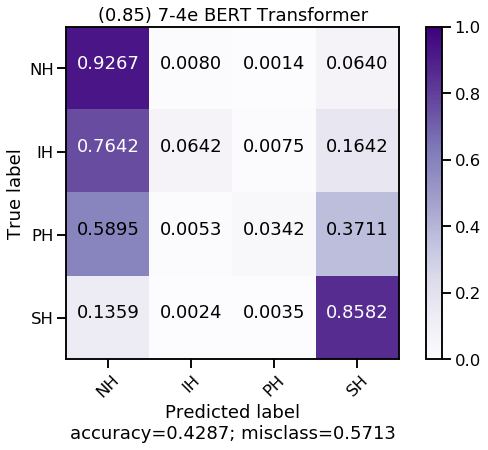

In [28]:
print ("con 7 y 4 epochs...\n")

print ("Acc:",np.mean(np.asarray(global_accs)))
print ("F-score:", np.mean(np.asarray(global_fmacros)))
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])

print ("(0.85) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in global_cms:
    m_temp+=np.asarray(m)
print (m_temp)

plot_confusion_matrix(normalize(m_temp),["NH","IH","PH","SH"],"(0.85) 7-4e BERT Transformer", cmap='Purples')

[0.85] Encoder Layer Attention head Promedio 0


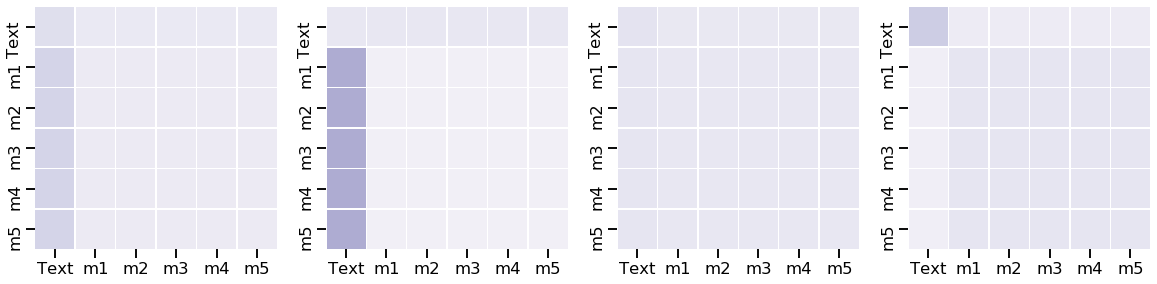

[0.85] Encoder Layer Attention head Promedio 1


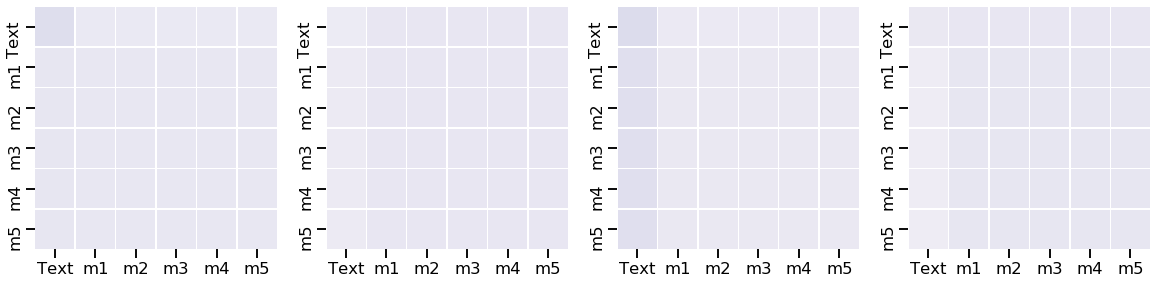

In [29]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("[0.85] Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="Purples", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()
    
for h in range(2):
    for hy in range(4):
        to_mean=dict_attn_enc[str(h)+str(hy)]
        at=np.zeros((6,6))
        for m in to_mean:
            at+=m.numpy()
        global_attn.append(at/5.)
        
np.save("Attn_BERT_85_ECML_26e_74_24000.npy", global_attn)